In [1]:
import numpy as np

import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import matplotlib as matplotlib

#%matplotlib inline
#from matplotlib.patches import Ellipse

%matplotlib notebook

import math

import matplotlib.patches as mpatches

## splash particle simulation


series of integrations as a function of stopping time. 
This set in physical units. 

nesc_2D*.png figures made here

In [2]:
# first create a particle in unit circle impact parameter
# returns a vector [x,y,z] on sphere
def create_pj():
    phi = np.random.uniform(low=0,high=2*np.pi)
    z  = np.random.uniform(low=0,high=1)
    x = np.sqrt(z)*np.cos(phi)  # sqrt makes distribution even on circle
    y = np.sqrt(z)*np.sin(phi)
    z = np.sqrt(1 - x**2 - y**2)
    r = np.array([x,y,z]) # returns a vector 
    return r  # impact point on sphere, units R_a radius of planetesimal



In [3]:
# create a rotation matrix, rotates about axis, an angle theta in radians
def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta in radians.
    https://en.wikipedia.org/wiki/Euler%E2%80%93Rodrigues_formula
    """
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))  # normalize axis
    a = np.cos(theta/2.0)
    b, c, d = -axis * np.sin(theta/2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

# how to call this routine
# v = [3, 5, 0]
# axis = [4, 4, 1]
# theta = 1.2  (radians)
# do rotation 
#  rot_vec = np.dot(rotation_matrix(axis, theta), v)) 
# print(np.dot(rotation_matrix(axis, theta), v)) 


# compute a velocity direction for a splash particle 
# this creates a 45 degree from normal direction from x,y,z on sphere and downrange 
# inputs: 
#    r should be an array [x,y,z] and unit vector 
#    u is impact velocity direction (-zhat if coming from north pole)
# returns: unit vector in 45 degree direction from local normal and in plane 
#  spanned by impact velocity and local normal  
#  should be away from velocity direction -- in the downrange direction!
def create_splash_dir(r,u):
    rhat = np.copy(r)/np.sqrt(np.dot(r,r))
    uhat = np.copy(u)/np.sqrt(np.dot(u,u))
    dvec = uhat - np.dot(uhat,rhat)*rhat 
    dvec_mag = np.sqrt(np.dot(dvec,dvec))
    dvec_hat = dvec/dvec_mag  # this is down range vector!!!! 
    vhat2 = dvec_hat *np.cos(45*np.pi/180) + rhat*np.sin(45*np.pi/180)  # elevation of 45 degrees and downrange
    vm = np.sqrt(np.dot(vhat2,vhat2))
    vhat2 /= vm 
    #print(vhat2)
    return np.array(vhat2)
    


In [4]:
# Create a splash velocity with a power law distribution
# here returned velocity is in range [a,b] with pdf(v) \propto v^beta
# negative powers are ok
# assumed units v/v_a v_a = np.sqrt(GM_a/R_a) gravitational 
def rndm(a, b, beta, size=1):
    # we want pdf(x) dx propto x^beta ;  this means that g-1 = beta
    # and g = beta+1
    g = beta+1.
    # Power-law gen for pdf(x)dx \propto x^{g-1} for a<=x<=b"""
    r = np.random.random(size=size)  # [0,1] uniform distrn
    ag, bg = a**g, b**g
    return (ag + (bg - ag)*r)**(1./g)


# If we have rotation we need to add a surface rotation speed to our velocity velocity
# Here tilde_Omega_a_vec is a spin vector for the asteroid in units of Omega_a = sqrt(GM_a/R_a^3)
# r is in units of R_a, returned velocity in units of v_a
# returns Omega x r
# used in generating initial conditions for integrations 
def v_rotation(r,tilde_Omega_a_vec):
    v_rot = np.cross(tilde_Omega_a_vec,r) # tilde omega x r
    return np.array(v_rot)



In [5]:
# full routine to create a splash particle
# arguments:
#   tilde_uhw is headwind velocity in grav units 
#   vmax, vmax_vmin_ratio gives range of velocities for splashed particles [vmin,vmax]
#   assuming impact at tilde_uhw velocity 
#      with vmin = vmax/vmax_vmin_ratio 
#         vmax is equal to C_1 u_pj/v_a which sets max splash velocity in grav units 
#         vmax is computed using projectile velocity u_pj = u_hw
#         vmax_vmin_ratio should be about 23 I think using crater scaling for min ejecta velocity 
#   tilde_Omega_a_vec is spin vector of planetesimal in units of Omega_a = sqrt(GM_a/R_a^3)
# returns position vector and velocity vector of splash particle, gravitational units
# 
def create_splash(tilde_uhw,vmax,vmax_vmin_ratio,tilde_Omega_a_vec):
    r = create_pj()  # find initial impact point on upper hemisphere, r is a vector 
    # compute surface rotation vector 
    v_rot = v_rotation(r,tilde_Omega_a_vec)
    zhat = np.array([0,0,1])
    v_impact = -1*tilde_uhw*zhat  # impact velocity in inertial frame 
    v_impact_rf = v_impact - v_rot  # impact velocity in rotating frame 
    v_impact_rf_mag = np.sqrt(np.dot(v_impact_rf,v_impact_rf))
    v_impact_rf_hat = v_impact_rf/v_impact_rf_mag
    vhat = create_splash_dir(r,v_impact_rf_hat)  # get unit vector for splash particle direction 
    # in rotating frame 
    v_impact_ratio = v_impact_rf_mag/tilde_uhw  # would be 1 if no rotation 
    vmin_rf = vmax/vmax_vmin_ratio  * v_impact_ratio   # min velocity in rotating frame 
    vmax_rf = vmax*v_impact_ratio  # max velocity in rotating frame 
    mu = 0.4  # power from Housen and Holsapple 2011
    beta = -3.0*mu-1.0  # power for velocity distribution
    # get an ejecta velocity using power law distribution 
    vmag = rndm(vmin_rf, vmax_rf, beta, size=1)  # now we have a velocity magnitude, using power law distn
    vej = vmag*vhat  # create velocity vector of splash particle in rotating frame 
    vej += v_rot # rotate back into inertial frame 
    #print(r,vej)
    return r, vej  # return position and velocity of splashed particle in inertial frame 

<IPython.core.display.Javascript object>


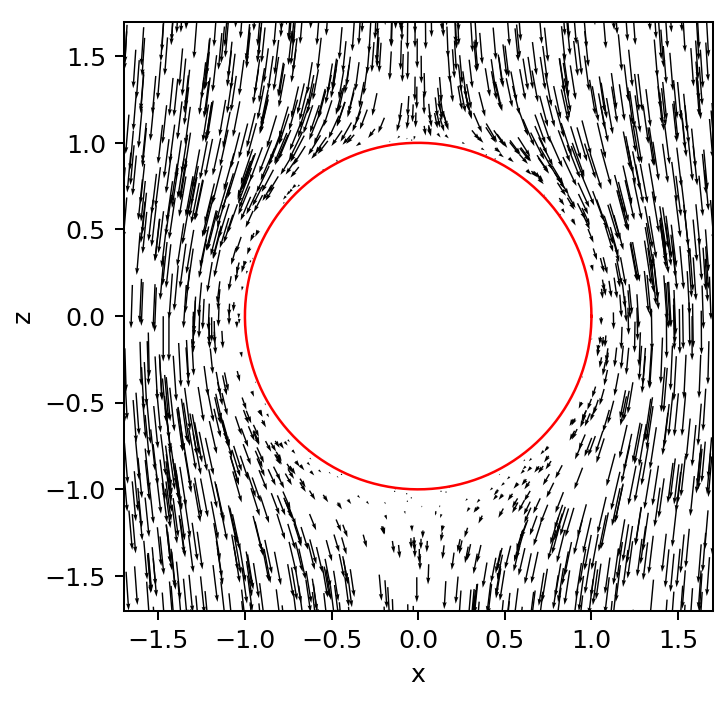

In [6]:
# return velocity vector of wind, in units of v_a = sqrt(GM_a/R_a)
# arguments:
#    rvec position vector, not necessarily on sphere, could be above sphere 
#    tilde_uhw is equal to wind velocity at large radius in units of v_a
#    Re is Reynolds number of flow (about whole planetesimal)
#    omega_vec is spin vector gravitational units
# returns: uvec, velocity vector of wind 
# we assume that wind comes from -z direction, potential flow model 
# BUT with a delta = sqrt(x/Re) Blasius boundary layer giving shear a velocity near surface, no slip
def u_wind_Bl(rvec,tilde_uhw,Re,omega_vec):
    x = rvec[0]; y = rvec[1]; z = rvec[2]
    rmag = np.sqrt(x**2 + y**2 + z**2)
    y_Bl = rmag - 1.0  # distance to surface 
    if (y_Bl <0):
        return 0.0  # cutoff no wind within surface 
    rhat = rvec/rmag
    vrot = v_rotation(rhat,omega_vec)  # rotation velocity of surface 
    fxy = 1.0
    if (Re>0):  # you can run without Boundary layer if you set Re negative or 0
        ctheta = z/rmag  # [-1,1] range
        x_Bl = np.arccos(ctheta)# distance along surface for Bl is always positive , range [0,pi] 
        delta_Bl = np.sqrt((x_Bl + 1e-6)/Re)   # boundary layer thickness, 1e-6 is a trap for x=0 problems
        if (y_Bl < delta_Bl):  # only correct flow within Boundary layer
            fxy = y_Bl/delta_Bl  # this goes from 0 to 1 in boundary layer
     
    # now compute potential flow model
    r3 = rmag**3
    r5 = rmag**5
    r2 = rmag**2
    z2 = z**2
    ux = 1.5*z*x/r5
    uy = 1.5*z*y/r5
    uz = -1 - (0.5/r3)*(1. - 3*z2/r2)
    uvec = np.array([ux,uy,uz])*tilde_uhw  # this is potential flow velocity  
    
    return uvec * fxy  + (1.0 - fxy) * vrot


# make a test routine for u_wind()
def test_u_wind_Bl(Re,ofile,omega_vec):
    tilde_uhw = 1.0
    nn = 2000
    uxarr = np.zeros(nn); uyarr = np.zeros(nn); uzarr = np.zeros(nn)
    xarr  = np.zeros(nn); yarr  = np.zeros(nn); zarr  = np.zeros(nn)
    
    for i in range(nn):
        phi = np.random.uniform(low=0,high=2*np.pi)
        rs = np.random.uniform(low=1.0,high=2.4)
        x = rs*np.cos(phi)
        y = 0.0
        z = rs*np.sin(phi)
        xarr[i] = x; yarr[i] = y; zarr[i] = z
        rvec = np.array([x, y, z])
        uvec = u_wind_Bl(rvec,tilde_uhw,Re,omega_vec)
        uxarr[i] = uvec[0]; uyarr[i] = uvec[1]; uzarr[i] = uvec[2]
        
    fig,ax = plt.subplots(1,1,figsize=(4,4),dpi=100,facecolor='white')
    plt.subplots_adjust(left=0.17,right=0.98,top=0.98,bottom=0.15)
    mm = 1.7
    ax.set_xlim([-mm,mm])
    ax.set_ylim([-mm,mm])
    ax.set_aspect(1)
    ax.quiver(xarr,zarr,uxarr,uzarr,scale=15.0)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    
    phi = np.linspace(0,2*np.pi,300)
    xarr = np.cos(phi); yarr = np.sin(phi)
    ax.plot(xarr,yarr,'r-',lw=1)
    if (len(ofile)>3):
        plt.savefig(ofile,dpi=100)
    
Re = 10; ofile = ""; # ofile = "flow_10.png"  # with nice boundary layer!
omega_vec = np.array([0,0.001,0])
test_u_wind_Bl(Re,ofile,omega_vec)  #looks good!

In [8]:
# some routines for rotating arcs
# arguments:
#    r a position on surface of sphere (units R_a)
#    tilde_Omega_vec  a spin rotation vector  (units Omega_a)
#    Delta_t a  time (units Omega_a^-1)
# returns:
#    new r position after body has rotated 
def rotate_init_position(r,tilde_Omega_a_vec,Delta_t):
    spinval = np.sqrt(np.dot(tilde_Omega_a_vec,tilde_Omega_a_vec))
    spin_axis  = tilde_Omega_a_vec/spinval
    theta = spinval*Delta_t  # how far to rotate 
    rm = rotation_matrix(spin_axis, theta) # create rotation matrix
    new_r = np.dot(rm,r)  # rotate r vector 
    return new_r  # return rotated vector, sign of rotation has been checked 




In [10]:
# integrated splash particle one timestep of dt 
# arguments:
#  r is position vector (units R_a)
#  v is velocity vector (units v_a)
#  tilde_ts is stop time in gravitational units (units t_a= Omega_a^-1)
#  tilde_uhw is head wind velocity at infinity (units v_a)
#  Re reynolds number of whole flow
#  omega_vec is spin vector
#  dt step size units t_a 
# returns:
#   rnew, vnew:   new position and velocity after 1 timestep 
def do_integration_step_leapfrog(r,v,tilde_ts,tilde_uhw,Re,omega_vec,dt):
    rhalf = r + v*dt/2  #half drift step
    rmag = np.sqrt(np.dot(rhalf,rhalf))
    ac_grav = -rhalf/rmag**3   # acceleration from gravity force in gravity units
    uw = u_wind_Bl(rhalf,tilde_uhw,Re,omega_vec) # compute wind direction 
    ac_drag = (uw - v)/tilde_ts  # force in direction of wind, against motion, looks ok
    vnew = v + (ac_grav + ac_drag)*dt  # kick step
    rnew = rhalf + vnew*dt/2    # half drift step
    return rnew,vnew


# integrate splash particle until hits surface or escapes 
# arguments:
#  r_init is initial position vector (units R_a)
#  v_init is initial velocity vector (units v_a)
#  tilde_ts is stop time in gravitational units (units t_a= Omega_a^-1)
#  tilde_uhw is head wind velocity at infinity (units v_a)
#  Re reynolds number of whole flow
#  dt step size units t_a 
# returns: vectors of times, positions and velocities  
#   and a result which tells you what happened to the particle
def do_integration(r_init,v_init,tilde_ts,tilde_uhw,Re,omega_vec,dt):
    xarr = []; yarr = []; zarr = []
    vxarr = [];vyarr = [];vzarr = [];
    tarr = []
    r = r_init; v = v_init 
    x = r[0]; y = r[1]; z = r[2]
    vx = v[0]; vy = v[1]; vz = v[2]
    t = 0.0
    # store initial condition! 
    xarr = np.append(xarr,x); yarr = np.append(yarr,y); zarr = np.append(zarr,z)
    vxarr = np.append(vxarr,vx); vyarr = np.append(vyarr,vy); vzarr = np.append(vzarr,vz)
    tarr = np.append(tarr,t)
    fine = 1; #keep going until fine==0
    nsteps = 0 # keep track of how many steps we have done

    integration_result = -1 
    # is 0 if impacts surface at end
    # is 1 if particle escapes 
    # is 2 if integration took too long 
    while (fine==1):
        rnew,vnew = do_integration_step_leapfrog(r,v,tilde_ts,tilde_uhw,Re,omega_vec,dt) # take a step
        vmag = np.sqrt(np.dot(vnew,vnew))
        rmag = np.sqrt(np.dot(rnew,rnew))
        nsteps +=1
        if (vmag > 1.1* np.sqrt(2.) and (rmag>1.5)):
            fine=0  # well above escape velocity and away from planestimal so stop integration 
            integration_result = 1  
        if (rmag>2):  # trap for too far away
            fine=0;
            integration_result = 1  # escape
        if (rmag <0.999):
            fine=0  # below surface so stop integration 
            integration_result = 0    # impact 
        if (nsteps > 10000):  # trap for integration going on too long 
            fine=0
            integration_result = 2  
        if (fine>0): # we continue the integration 
            r = rnew
            v = vnew 
            x = r[0]; y = r[1]; z = r[2]
            vx = v[0]; vy = v[1]; vz = v[2]
            # store position and velocity 
            xarr = np.append(xarr,x); yarr = np.append(yarr,y); zarr = np.append(zarr,z)
            vxarr = np.append(vxarr,vx); vyarr = np.append(vyarr,vy); vzarr = np.append(vzarr,vz)
            t += dt
            tarr = np.append(tarr,t)
        
            
    return tarr,xarr,yarr,zarr,vxarr,vyarr,vzarr,integration_result




In [11]:

C_1 = 0.55  #crater scaling parm
mu = 0.4  # crater scaling exponent
G = 6.67430E-11 # N⋅m2⋅kg−2 grav constant mks
H_2 = 0.4 
n_1 = 1.2
pi_4 = 1.0
nu = 0.4

#rho_a = 1e3
#print('R_ratio ={:.2f}'.format(R_ratio))

# given planetesimal diameter in km and planetesimal density in kg m^-3
# get parameters needed in splash integrations 
def get_parms(D_a_km,rho_a,Y_a,u_hw):
    R_a = D_a_km*1e3/2  # Radius in m
    M_a = 4*np.pi*rho_a*R_a**3/3 # mass of planetesimal kg
    v_a = np.sqrt(G*M_a/R_a)  # velocity scale 
    Omega_a = v_a/R_a
    t_a = 1./Omega_a  # time unit
    tilde_uhw = u_hw/v_a     # wind velocity in grav units 
    pi_3 = Y_a/(rho_a*u_hw**2)
    R_ratio = (4.0*np.pi/3.)**0.33333 * H_2 * pi_3**(-mu/2) * pi_4**(-nu)
    vmax = tilde_uhw*C_1*pi_4**(-nu/mu)*n_1**(-1/mu)     # max velocity in grav units 
    vmin = tilde_uhw*C_1*pi_4**(-nu/mu)*R_ratio**(-1.0/mu) 
    vmax_vmin_ratio = vmax/vmin
    
    print('D_a_km={:.1f} km, v_a={:.1f} m/s, v_esc={:.1f}m/s, pi_3={:.1e}'.format(D_a_km,v_a,v_a*np.sqrt(2),pi_3))
    print('tilde_uhw={:.1f}, tilde_vmax={:.1f}, tilde_vmin={:.3f}, vmax_vmin_ratio={:.1f}'.format(\
                tilde_uhw,vmax,vmin,vmax_vmin_ratio))
    
    #print('D_a_km {:.0f}'.format(D_a_km))
    #print('pi_3 {:.1e}'.format(pi_3))
    #print('v_a {:.1f}'.format(v_a))
    #print('v_esc {:.1f}'.format(v_a*np.sqrt(2.)))  #escape vel in grav units
    #print('tilde_uhw {:.1f}'.format(tilde_uhw))
    #print('tilde vmax {:.1f}'.format(vmax))
    #print('vmax_vmin_ratio {:.1f}'.format(vmax_vmin_ratio))
    #print('tilde vmin {:.3f}'.format(vmin))   # minimum velocity in grav units 
    return tilde_uhw,vmax,vmax_vmin_ratio,v_a

 
# lets look at parameters for integrations 

u_hw = 47.0 # m/s  # setting by hand 
Y_a = 250.0
D_a_km = 20.
rho_a = 250.
tilde_uhw_20,vmax_20,vmax_vmin_ratio_20,v_20 = get_parms(D_a_km,rho_a,Y_a,u_hw)
print("")

u_hw = 47.0 # m/s  # setting by hand 
Y_a = 500.0
D_a_km = 10.
rho_a = 1000.
tilde_uhw_10,vmax_10,vmax_vmin_ratio_10,v_10 = get_parms(D_a_km,rho_a,Y_a,u_hw)

print("")
D_a_km = 31.
tilde_uhw_31,vmax_31,vmax_vmin_ratio_31,v_31 = get_parms(D_a_km,rho_a,Y_a,u_hw)

print("")
D_a_km = 100.
tilde_uhw_100,vmax_100,vmax_vmin_ratio_100,v_100 = get_parms(D_a_km,rho_a,Y_a,u_hw)

D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=4.5e-04
tilde_uhw=17.8, tilde_vmax=6.2, tilde_vmin=0.623, vmax_vmin_ratio=9.9

D_a_km=10.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=2.3e-04
tilde_uhw=17.8, tilde_vmax=6.2, tilde_vmin=0.441, vmax_vmin_ratio=14.1

D_a_km=31.0 km, v_a=8.2 m/s, v_esc=11.6m/s, pi_3=2.3e-04
tilde_uhw=5.7, tilde_vmax=2.0, tilde_vmin=0.142, vmax_vmin_ratio=14.1

D_a_km=100.0 km, v_a=26.4 m/s, v_esc=37.4m/s, pi_3=2.3e-04
tilde_uhw=1.8, tilde_vmax=0.6, tilde_vmin=0.044, vmax_vmin_ratio=14.1


In [12]:
# given planetesimal mass in kg and planetesimal density in kg m^-3
# get parameters needed in splash integrations 
def get_parms_M(M_a,rho_a,Y_a,u_hw):
    R_a = ( (M_a/rho_a)*(3./(4*np.pi)) )**(1./3.) # Radius in m
    D_a_km = 2*R_a/1e3
    #R_a = D_a_km*1e3/2  
    #M_a = 4*np.pi*rho_a*R_a**3/3 # mass of planetesimal kg
    v_a = np.sqrt(G*M_a/R_a)  # velocity scale 
    Omega_a = v_a/R_a
    t_a = 1./Omega_a  # time unit
    tilde_uhw = u_hw/v_a     # wind velocity in grav units 
    
    pi_3 = Y_a/(rho_a*u_hw**2)
    R_ratio = (4.0*np.pi/3.)**0.33333 * H_2 * pi_3**(-mu/2) * pi_4**(-nu)
    vmax = tilde_uhw*C_1*pi_4**(-nu/mu)*n_1**(-1/mu)     # max velocity in grav units 
    vmin = tilde_uhw*C_1*pi_4**(-nu/mu)*R_ratio**(-1.0/mu) 
    vmax_vmin_ratio = vmax/vmin
    
    print('D_a_km={:.2f} km, v_a={:.2f} m/s, v_esc={:.2f}m/s, pi_3={:.2e}'.format(D_a_km,v_a,v_a*np.sqrt(2),pi_3))
    print('tilde_uhw={:.2f}, tilde_vmax={:.2f}, tilde_vmin={:.3f}, vmax_vmin_ratio={:.2f}'.format(\
                tilde_uhw,vmax,vmin,vmax_vmin_ratio))
    #print('pi_3 {:.1e}'.format(pi_3))
    #print('v_a {:.1f}'.format(v_a))
    #print('v_esc {:.1f}'.format(v_a*np.sqrt(2.)))  #escape vel in grav units
    
    #print('tilde vmax {:.1f}'.format(vmax))
    #print('vmax_vmin_ratio {:.1f}'.format(vmax_vmin_ratio))
    #print('tilde vmin {:.3f}'.format(vmin))   # minimum velocity in grav units 
    return tilde_uhw,vmax,vmax_vmin_ratio,v_a

print("")
M_a = 7.5e14 # kg  for Arrokoth
rho_a = 250.
u_hw=47.
Y_a=250
tilde_uhw,vmax,vmax_vmin_ratio,v_a = get_parms_M(M_a,rho_a,Y_a,u_hw)


D_a_km=17.89 km, v_a=2.37 m/s, v_esc=3.35m/s, pi_3=4.53e-04
tilde_uhw=19.87, tilde_vmax=6.93, tilde_vmin=0.696, vmax_vmin_ratio=9.95


In [13]:
# let's get some statistics from integrations 
# nc is number of points
# return number of escape particles and angular distances travelled if no escape 
def stats1(nc,tilde_Omega_a_vec,vmax,vmax_vmin_ratio,tilde_ts,tilde_uhw,Re,dt):
    dtheta_arr = []
    nesc = 0
    for i in range(nc): # number of integrations 
        r_init,v_init  = create_splash(tilde_uhw,vmax,vmax_vmin_ratio,tilde_Omega_a_vec);  # get initial conditions 
        # do integration 
        tarr,xarr,yarr,zarr,vxarr,vyarr,vzarr,result=do_integration(r_init,v_init,tilde_ts,\
                                            tilde_uhw,Re,tilde_Omega_a_vec,dt)
        if (result ==1):  # escape particle 
            nesc += 1 
        else :  # no escape!!!
            r_final = np.array([xarr[-1],yarr[-1],zarr[-1]])
            r_final_mag = np.sqrt(np.dot(r_final,r_final))
            r_final /= r_final_mag
            # find where particle would have been if just rotating with planetesimal
            tmax = tarr[-1]
            r_rot = rotate_init_position(r_init,tilde_Omega_a_vec,tmax) 
            r_rot_mag = np.sqrt(np.dot(r_rot,r_rot))
            r_rot /= r_rot_mag
            dtheta = np.arccos(np.dot(r_final,r_rot)) # angle between rotated point and landing point 
            dtheta_arr = np.append(dtheta_arr,dtheta)  
    return dtheta_arr, nesc


# let's get some statistics from integrations 
# nc is number of points
# return number of escape particles and angular distances travelled if no escape 
# more information returned
def stats2(nc,tilde_Omega_a_vec,vmax,vmax_vmin_ratio,tilde_ts,tilde_uhw,Re,dt):
    dtheta_arr = []
    theta_init_arr = []
    theta_final_arr = []
    nesc = 0
    for i in range(nc): # number of integrations 
        r_init,v_init  = create_splash(tilde_uhw,vmax,vmax_vmin_ratio,tilde_Omega_a_vec);  # get initial conditions 
        # do integration 
        tarr,xarr,yarr,zarr,vxarr,vyarr,vzarr,result=do_integration(r_init,v_init,tilde_ts,\
                                                    tilde_uhw,Re,tilde_Omega_a_vec,dt)
        rmag = np.sqrt(np.dot(r_init,r_init))
        z = r_init[2]
        theta_init =np.arccos(z/rmag)
        theta_init_arr = np.append(theta_init_arr,theta_init)
        if (result ==1):  # escape particle 
            nesc += 1 
            theta_final_arr = np.append(theta_final_arr,-100) # appends -100 if escaped!
            dtheta_arr = np.append(dtheta_arr,-100)
        else :
            r_final = np.array([xarr[-1],yarr[-1],zarr[-1]])
            r_final_mag = np.sqrt(np.dot(r_final,r_final))
            z_final = r_final[2]
            theta_final = np.arccos(z_final/r_final_mag)
            theta_final_arr = np.append(theta_final_arr,theta_final)
            r_final_hat = r_final/r_final_mag
            # find where particle would have been if just rotating with planetesimal
            tmax = tarr[-1]
            r_rot = rotate_init_position(r_init,tilde_Omega_a_vec,tmax) 
            r_rot_mag = np.sqrt(np.dot(r_rot,r_rot))
            r_rot /= r_rot_mag
            dtheta = np.arccos(np.dot(r_final_hat,r_rot)) # angle between rotated point and landing point 
            dtheta_arr = np.append(dtheta_arr,dtheta)  # in 0 to pi?
    return dtheta_arr, nesc,theta_init_arr,theta_final_arr


# from D_a in km and rho_a give vescape 
def vesc_D(Dkm,rho_a):
    R_a = Dkm*1e3/2
    M_a = 4.0*np.pi/3.0 * rho_a * R_a**3
    vesc = np.sqrt(2*G*M_a/R_a) # in m/s
    return vesc

# inverse of previous routine
def D_vesc(vesc,rho_a):
    R_a = vesc/np.sqrt(8*np.pi*G*rho_a/3)
    return 2*R_a/1e3  # returns D in km

In [14]:
#check fiducial model parameters
### important!!!! 
rho_a_fid = 250. # kg m-3
u_hw_fid = 50.0 # m/s  
Y_a_fid = 250.0 #Pa
D_a_km_fid = 20.0 #km
# on left we have dimensionless parameters tilde_uhw, vmax, vmin_vmax_ratio
# v_a on left is in m/s
tilde_uhw_fid,vmax_fid,vmax_vmin_ratio_fid,v_a_fid = get_parms(D_a_km_fid,rho_a_fid,Y_a_fid,u_hw_fid)
tilde_vmin_fid = vmax_fid/vmax_vmin_ratio_fid
print('v_ej,max/u_hw fid = {:.3f}'.format(vmax_fid/tilde_uhw_fid))
print('log_10 (tilde v_ej,max) = {:.3f}'.format(np.log10(vmax_fid)))
print('log_10 (tilde v_ej,min) = {:.3f}'.format(np.log10(tilde_vmin_fid)))
vesc_fid = (v_a_fid*np.sqrt(2)) # escape velocity in m/s for fid model
print('v_esc,a fid = {:.2f} m/s'.format(vesc_fid))

pi_3_fid = Y_a_fid/(rho_a_fid*u_hw_fid**2)
print('pi_3 fid ={:.2e}'.format(pi_3_fid))

D_crit_km_fid = D_vesc(u_hw_fid,rho_a_fid)  # planetesimal that has v_esc = u_hw
print('D_crit fid = {:.2f} km'.format(D_crit_km_fid))

D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=4.0e-04
tilde_uhw=18.9, tilde_vmax=6.6, tilde_vmin=0.623, vmax_vmin_ratio=10.6
v_ej,max/u_hw fid = 0.349
log_10 (tilde v_ej,max) = 0.819
log_10 (tilde v_ej,min) = -0.205
v_esc,a fid = 3.74 m/s
pi_3 fid =4.00e-04
D_crit fid = 267.47 km


In [15]:
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

# make a cute color map for the mean dtheta figures 
#cmapB = mpl.colormaps['summer_r'].resampled(256)
cmapB = mpl.colormaps['brg'].resampled(256)
newcolors = cmapB(np.linspace(0, 1, 256))
pk = np.array([256/256, 256/256, 256/256, 1]) # white
newcolors[0:1, :] = pk
newcmp = ListedColormap(newcolors)

In [16]:
# 2D parm sweep over t_s and D_a
ts_arr = np.logspace(-2,4.0,13)  # stopping times (dimensionless)
D_a_km_arr = np.logspace(1,2.3,10)
print(D_a_km_arr,ts_arr)

Re = 100  # Reynold number of whole body
theta_s_deg = 45.  # in degrees 
theta_s = theta_s_deg*np.pi/180.0   # in radians 
tilde_Omega_a = 0.001
tilde_Omega_a_vec = np.array([np.sin(theta_s), 0.0, np.cos(theta_s)]) *tilde_Omega_a
dt = 0.005  # timestep
nc = 100   # number of particles integrated 
rho_a = 250. #mks
u_hw = 50.0 # m/s  # setting by hand 
Y_a = 250.0

ts_2D,D_a_2D = np.meshgrid(ts_arr,D_a_km_arr)  # X,Y
lt_aa = np.log10(ts_2D)
lD_aa = np.log10(D_a_2D)
nesc_2D_aa = D_a_2D*0.0
mean_dt_aa = D_a_2D*0.0
for j in range(len(ts_arr)):
    print(j)
    for i in range(len(D_a_km_arr)):
        D_a_km = D_a_2D[i,j]
        tilde_ts = ts_2D[i,j]
        print('ts,Da',tilde_ts,D_a_km)
        tilde_uhw,vmax,vmax_vmin_ratio,v_a = get_parms(D_a_km,rho_a,Y_a,u_hw)
        dtheta_arr, nesc,theta_init_arr,theta_final_arr = \
            stats2(nc,tilde_Omega_a_vec,vmax,vmax_vmin_ratio,tilde_ts,tilde_uhw,Re,dt)
        nesc_2D_aa[i,j] = nesc/nc
        kk = (dtheta_arr >= 0)  # is Boolean
        nk = len(dtheta_arr[kk])
        if (nk>1):
            mean_dt_aa[i,j] = np.mean(dtheta_arr[kk])
        else:
            mean_dt_aa[i,j] = -100  # false value here

[ 10.          13.94583249  19.44862439  27.12272579  37.82489906
  52.74997064  73.56422545 102.59143655 143.07229892 199.5262315 ] [1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00 3.16227766e+00 1.00000000e+01 3.16227766e+01
 1.00000000e+02 3.16227766e+02 1.00000000e+03 3.16227766e+03
 1.00000000e+04]
0
ts,Da 0.01 10.0
D_a_km=10.0 km, v_a=1.3 m/s, v_esc=1.9m/s, pi_3=4.0e-04
tilde_uhw=37.8, tilde_vmax=13.2, tilde_vmin=1.246, vmax_vmin_ratio=10.6
ts,Da 0.01 13.94583249195745
D_a_km=13.9 km, v_a=1.8 m/s, v_esc=2.6m/s, pi_3=4.0e-04
tilde_uhw=27.1, tilde_vmax=9.5, tilde_vmin=0.894, vmax_vmin_ratio=10.6
ts,Da 0.01 19.448624389373617
D_a_km=19.4 km, v_a=2.6 m/s, v_esc=3.6m/s, pi_3=4.0e-04
tilde_uhw=19.4, tilde_vmax=6.8, tilde_vmin=0.641, vmax_vmin_ratio=10.6
ts,Da 0.01 27.12272579332028
D_a_km=27.1 km, v_a=3.6 m/s, v_esc=5.1m/s, pi_3=4.0e-04
tilde_uhw=13.9, tilde_vmax=4.9, tilde_vmin=0.460, vmax_vmin_ratio=10.6
ts,Da 0.01 37.824899063893845
D_a_km=37.8 km, v_a=5.

ts,Da 1.0 199.52623149688787
D_a_km=199.5 km, v_a=26.4 m/s, v_esc=37.3m/s, pi_3=4.0e-04
tilde_uhw=1.9, tilde_vmax=0.7, tilde_vmin=0.062, vmax_vmin_ratio=10.6
5
ts,Da 3.1622776601683795 10.0
D_a_km=10.0 km, v_a=1.3 m/s, v_esc=1.9m/s, pi_3=4.0e-04
tilde_uhw=37.8, tilde_vmax=13.2, tilde_vmin=1.246, vmax_vmin_ratio=10.6
ts,Da 3.1622776601683795 13.94583249195745
D_a_km=13.9 km, v_a=1.8 m/s, v_esc=2.6m/s, pi_3=4.0e-04
tilde_uhw=27.1, tilde_vmax=9.5, tilde_vmin=0.894, vmax_vmin_ratio=10.6
ts,Da 3.1622776601683795 19.448624389373617
D_a_km=19.4 km, v_a=2.6 m/s, v_esc=3.6m/s, pi_3=4.0e-04
tilde_uhw=19.4, tilde_vmax=6.8, tilde_vmin=0.641, vmax_vmin_ratio=10.6
ts,Da 3.1622776601683795 27.12272579332028
D_a_km=27.1 km, v_a=3.6 m/s, v_esc=5.1m/s, pi_3=4.0e-04
tilde_uhw=13.9, tilde_vmax=4.9, tilde_vmin=0.460, vmax_vmin_ratio=10.6
ts,Da 3.1622776601683795 37.824899063893845
D_a_km=37.8 km, v_a=5.0 m/s, v_esc=7.1m/s, pi_3=4.0e-04
tilde_uhw=10.0, tilde_vmax=3.5, tilde_vmin=0.329, vmax_vmin_ratio=10.6


ts,Da 316.22776601683796 199.52623149688787
D_a_km=199.5 km, v_a=26.4 m/s, v_esc=37.3m/s, pi_3=4.0e-04
tilde_uhw=1.9, tilde_vmax=0.7, tilde_vmin=0.062, vmax_vmin_ratio=10.6
10
ts,Da 1000.0 10.0
D_a_km=10.0 km, v_a=1.3 m/s, v_esc=1.9m/s, pi_3=4.0e-04
tilde_uhw=37.8, tilde_vmax=13.2, tilde_vmin=1.246, vmax_vmin_ratio=10.6
ts,Da 1000.0 13.94583249195745
D_a_km=13.9 km, v_a=1.8 m/s, v_esc=2.6m/s, pi_3=4.0e-04
tilde_uhw=27.1, tilde_vmax=9.5, tilde_vmin=0.894, vmax_vmin_ratio=10.6
ts,Da 1000.0 19.448624389373617
D_a_km=19.4 km, v_a=2.6 m/s, v_esc=3.6m/s, pi_3=4.0e-04
tilde_uhw=19.4, tilde_vmax=6.8, tilde_vmin=0.641, vmax_vmin_ratio=10.6
ts,Da 1000.0 27.12272579332028
D_a_km=27.1 km, v_a=3.6 m/s, v_esc=5.1m/s, pi_3=4.0e-04
tilde_uhw=13.9, tilde_vmax=4.9, tilde_vmin=0.460, vmax_vmin_ratio=10.6
ts,Da 1000.0 37.824899063893845
D_a_km=37.8 km, v_a=5.0 m/s, v_esc=7.1m/s, pi_3=4.0e-04
tilde_uhw=10.0, tilde_vmax=3.5, tilde_vmin=0.329, vmax_vmin_ratio=10.6
ts,Da 1000.0 52.749970637026166
D_a_km=52.7 

<IPython.core.display.Javascript object>


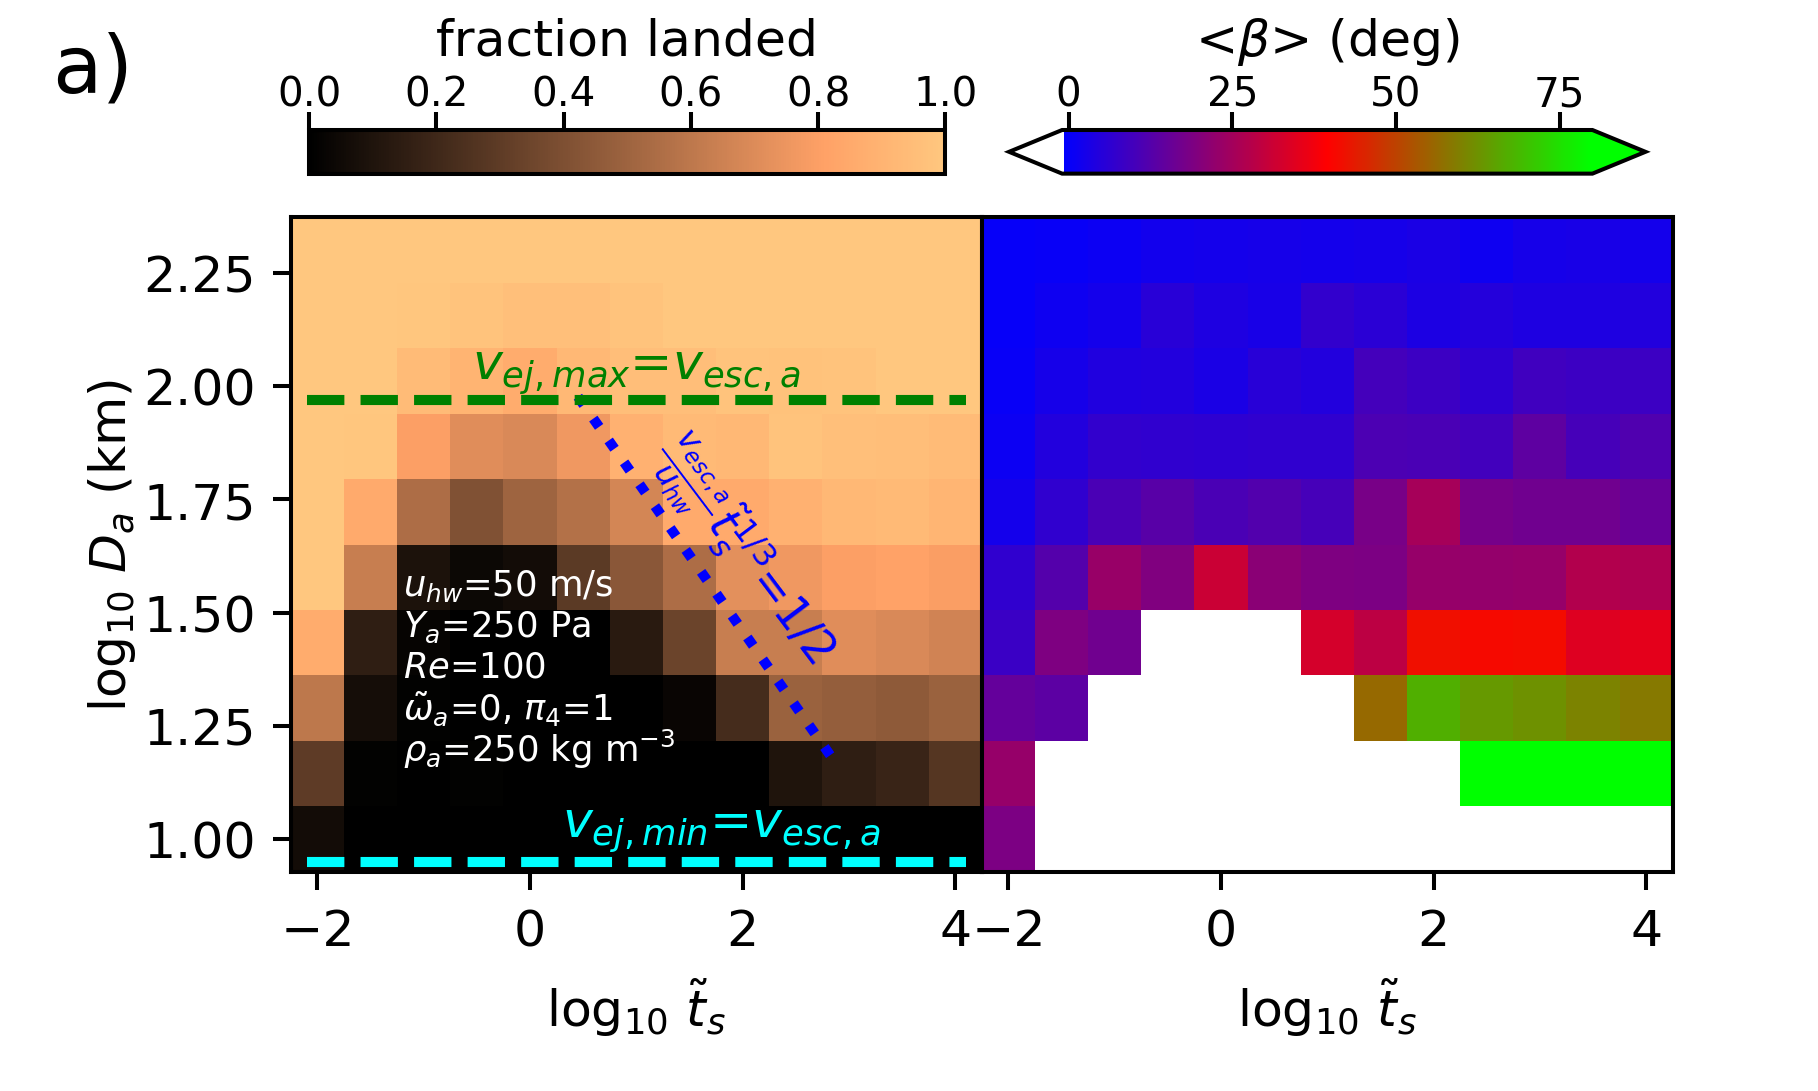

17.43 93.26
1.65 8.90


In [17]:
fig,axarr = plt.subplots(1,2,figsize=(5,3),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.16,right=0.92,top=0.80,bottom=0.2,hspace=0,wspace=0)
axarr[0].set_xlabel(r'log$_{10}$ $\tilde t_s$')
axarr[0].set_ylabel(r'log$_{10}$ $D_a$ (km)',labelpad=1)
axarr[1].set_xlabel(r'log$_{10}$ $\tilde t_s$')
axarr[1].set_yticks([])
cax1 = plt.axes((0.17, 0.84, 0.35, 0.04))
cax1.tick_params(labelsize=8,pad=-0.5)
cax2 = plt.axes((0.555, 0.84, 0.35, 0.04))
cax2.tick_params(labelsize=8,pad=-0.5)

im=axarr[0].pcolormesh(lt_aa, lD_aa,1-nesc_2D_aa,shading='auto',cmap='copper',vmin=0,vmax=1)
cbar = plt.colorbar(im,cax = cax1, location='top')
cbar.set_label(label='fraction landed',size=10)
im2=axarr[1].pcolormesh(lt_aa, lD_aa,mean_dt_aa*180/np.pi,shading='auto',cmap=newcmp,vmin=-1,vmax=80) 
cbar2=plt.colorbar(im2,extend='both',extendfrac=0.1,cax = cax2, location='top')
cbar2.set_label(label=r'<$\beta$> (deg)',size=10)

xll = -1.2
dz = 0.09; y0=1.2
lcolor ='white'
axarr[0].text(xll,y0,r'$\rho_a$=250 kg m$^{-3}$',va='center',ha='left',fontsize=7,color=lcolor)
axarr[0].text(xll,y0+dz, r'$\tilde\omega_a$=0, $\pi_4$=1',va='center',ha='left',fontsize=7,color=lcolor)
axarr[0].text(xll,y0+dz*2, r'$Re$=$100$',va='center',ha='left',fontsize=7,color=lcolor)
axarr[0].text(xll,y0+dz*3, r'$Y_{a}$=250 Pa',va='center',ha='left',fontsize=7,color=lcolor)
axarr[0].text(xll,y0+dz*4, r'$u_{hw}$=50 m/s',va='center',ha='left',fontsize=7,color=lcolor)

tlin = np.linspace(0.45,2.9,10)  # log ts 
ts = 10**tlin
Dlin = 1*u_hw/np.sqrt(8/3*np.pi*G*rho_a)*ts**-0.333333 / 1e3
lDlin = np.log10(Dlin)
# this relation is  u_hw/vescape ts**-1/3 = 2
# which is vesc/u_hw ts**1/3 = 0.5
axarr[0].text(1.0,1.4,r'$\frac{v_{esc,a}}{u_{hw}}$$\tilde t_s^{1/3}$=1/2',rotation=-53,color='blue',fontsize=9)
axarr[0].plot(tlin,lDlin,':',lw=2,color='blue')

vmax_ms = vmax_fid*v_a_fid  # value of vmax in m/s for fiducial model 
Dvej = D_vesc(vmax_ms,rho_a_fid) # diameter in km where v_ej,max = vesc,a
print('{:.2f} {:.2f}'.format( vmax_ms, Dvej))
axarr[0].plot([-2.1,4.1],[np.log10(Dvej),np.log10(Dvej)],'g--',lw=2)
axarr[0].text(1,2.03,r'$v_{ej,max}$=$v_{esc,a}$',color='green',ha='center',va='center')

vmin_ms = vmax_ms/vmax_vmin_ratio_fid
Dvej2 = D_vesc(vmin_ms,rho_a_fid)*1.01 # diameter in km where v_ej,min = vesc,a
print('{:.2f} {:.2f}'.format(vmin_ms, Dvej2))
axarr[0].plot([-2.1,4.1],[np.log10(Dvej2),np.log10(Dvej2)],'--',color='cyan',lw=2)
axarr[0].text(1.8,1.02,r'$v_{ej,min}$=$v_{esc,a}$',color='cyan',ha='center',va='center')

lD_crit_fid = np.log10(D_crit_km_fid) # vesc = uhw 
#print(lD_crit_fid) # is 2.43 and above plot so not plotting it

axarr[0].text(-4.5,2.65,'a)',fontsize=16)
plt.savefig('nesc_2D_Da.png',dpi=200)

In [19]:
# parm sweep ts and log uhw
ts_arr = np.logspace(-2,4.0,13)  # stopping times (dimensionless)
u_fac = np.logspace(-1,0.3,9)  #0.1 to 2 times u_hw
print(u_fac,ts_arr)

Re_1 = 100  # Reynold number of whole body
theta_s_deg = 45.  # in degrees 
theta_s = theta_s_deg*np.pi/180.0   # in radians 
tilde_Omega_a = 0.001
tilde_Omega_a_vec = np.array([np.sin(theta_s), 0.0, np.cos(theta_s)]) *tilde_Omega_a
dt = 0.005  # timestep
nc = 100   # number of particles integrated 
rho_a = 250. #mks
u_hw = 50.0 # m/s  # setting by hand,  just used for scaling here
Y_a = 250.0

ts_2D,u_2D_h = np.meshgrid(ts_arr,u_fac)  # X,Y
lt_h = np.log10(ts_2D)
lu_h = np.log10(u_2D_h*u_hw)

nesc_2D_h = u_2D_h*0.0
mean_dt_h = u_2D_h*0.0

D_a_km = 20.0
for j in range(len(ts_arr)):
    print(j)
    for i in range(len(u_fac)):
        uf = u_2D_h[i,j]
        Re = Re_1*uf  # adjusting Re
        tilde_ts = ts_2D[i,j]
        print('ts,uf',tilde_ts,uf)
        tilde_uhw,vmax,vmax_vmin_ratio,v_a = get_parms(D_a_km,rho_a,Y_a,u_hw*uf)  # adjusting u_hw
        dtheta_arr,nesc,theta_init_arr,theta_final_arr = \
            stats2(nc,tilde_Omega_a_vec,vmax,vmax_vmin_ratio,tilde_ts,tilde_uhw,Re,dt)
        nesc_2D_h[i,j] = nesc/nc
        kk = (dtheta_arr >= 0)  # is Boolean
        nk = len(dtheta_arr[kk])
        if (nk>1):
            mean_dt_h[i,j] = np.mean(dtheta_arr[kk])
        else:
            mean_dt_h[i,j] = -100  # false value here

[0.1        0.14537844 0.2113489  0.30725574 0.44668359 0.64938163
 0.94406088 1.37246096 1.99526231] [1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00 3.16227766e+00 1.00000000e+01 3.16227766e+01
 1.00000000e+02 3.16227766e+02 1.00000000e+03 3.16227766e+03
 1.00000000e+04]
0
ts,uf 0.01 0.1
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=4.0e-02
tilde_uhw=1.9, tilde_vmax=0.7, tilde_vmin=0.623, vmax_vmin_ratio=1.1
ts,uf 0.01 0.14537843856076618
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=1.9e-02
tilde_uhw=2.7, tilde_vmax=1.0, tilde_vmin=0.623, vmax_vmin_ratio=1.5
ts,uf 0.01 0.21134890398366465
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=9.0e-03
tilde_uhw=4.0, tilde_vmax=1.4, tilde_vmin=0.623, vmax_vmin_ratio=2.2
ts,uf 0.01 0.3072557365267447
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=4.2e-03
tilde_uhw=5.8, tilde_vmax=2.0, tilde_vmin=0.623, vmax_vmin_ratio=3.3
ts,uf 0.01 0.44668359215096315
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=2.0e-03
ti

ts,uf 3.1622776601683795 0.6493816315762113
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=9.5e-04
tilde_uhw=12.3, tilde_vmax=4.3, tilde_vmin=0.623, vmax_vmin_ratio=6.9
ts,uf 3.1622776601683795 0.9440608762859236
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=4.5e-04
tilde_uhw=17.9, tilde_vmax=6.2, tilde_vmin=0.623, vmax_vmin_ratio=10.0
ts,uf 3.1622776601683795 1.3724609610075618
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=2.1e-04
tilde_uhw=26.0, tilde_vmax=9.1, tilde_vmin=0.623, vmax_vmin_ratio=14.5
ts,uf 3.1622776601683795 1.9952623149688795
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=1.0e-04
tilde_uhw=37.7, tilde_vmax=13.2, tilde_vmin=0.623, vmax_vmin_ratio=21.1
6
ts,uf 10.0 0.1
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=4.0e-02
tilde_uhw=1.9, tilde_vmax=0.7, tilde_vmin=0.623, vmax_vmin_ratio=1.1
ts,uf 10.0 0.14537843856076618
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=1.9e-02
tilde_uhw=2.7, tilde_vmax=1.0, tilde_vmin=0.623, vmax_vmin_ratio=1.5
ts,uf 10.0 0.21134

ts,uf 3162.2776601683795 0.21134890398366465
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=9.0e-03
tilde_uhw=4.0, tilde_vmax=1.4, tilde_vmin=0.623, vmax_vmin_ratio=2.2
ts,uf 3162.2776601683795 0.3072557365267447
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=4.2e-03
tilde_uhw=5.8, tilde_vmax=2.0, tilde_vmin=0.623, vmax_vmin_ratio=3.3
ts,uf 3162.2776601683795 0.44668359215096315
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=2.0e-03
tilde_uhw=8.4, tilde_vmax=2.9, tilde_vmin=0.623, vmax_vmin_ratio=4.7
ts,uf 3162.2776601683795 0.6493816315762113
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=9.5e-04
tilde_uhw=12.3, tilde_vmax=4.3, tilde_vmin=0.623, vmax_vmin_ratio=6.9
ts,uf 3162.2776601683795 0.9440608762859236
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=4.5e-04
tilde_uhw=17.9, tilde_vmax=6.2, tilde_vmin=0.623, vmax_vmin_ratio=10.0
ts,uf 3162.2776601683795 1.3724609610075618
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=2.1e-04
tilde_uhw=26.0, tilde_vmax=9.1, tilde_vmin=0.623, 

<IPython.core.display.Javascript object>


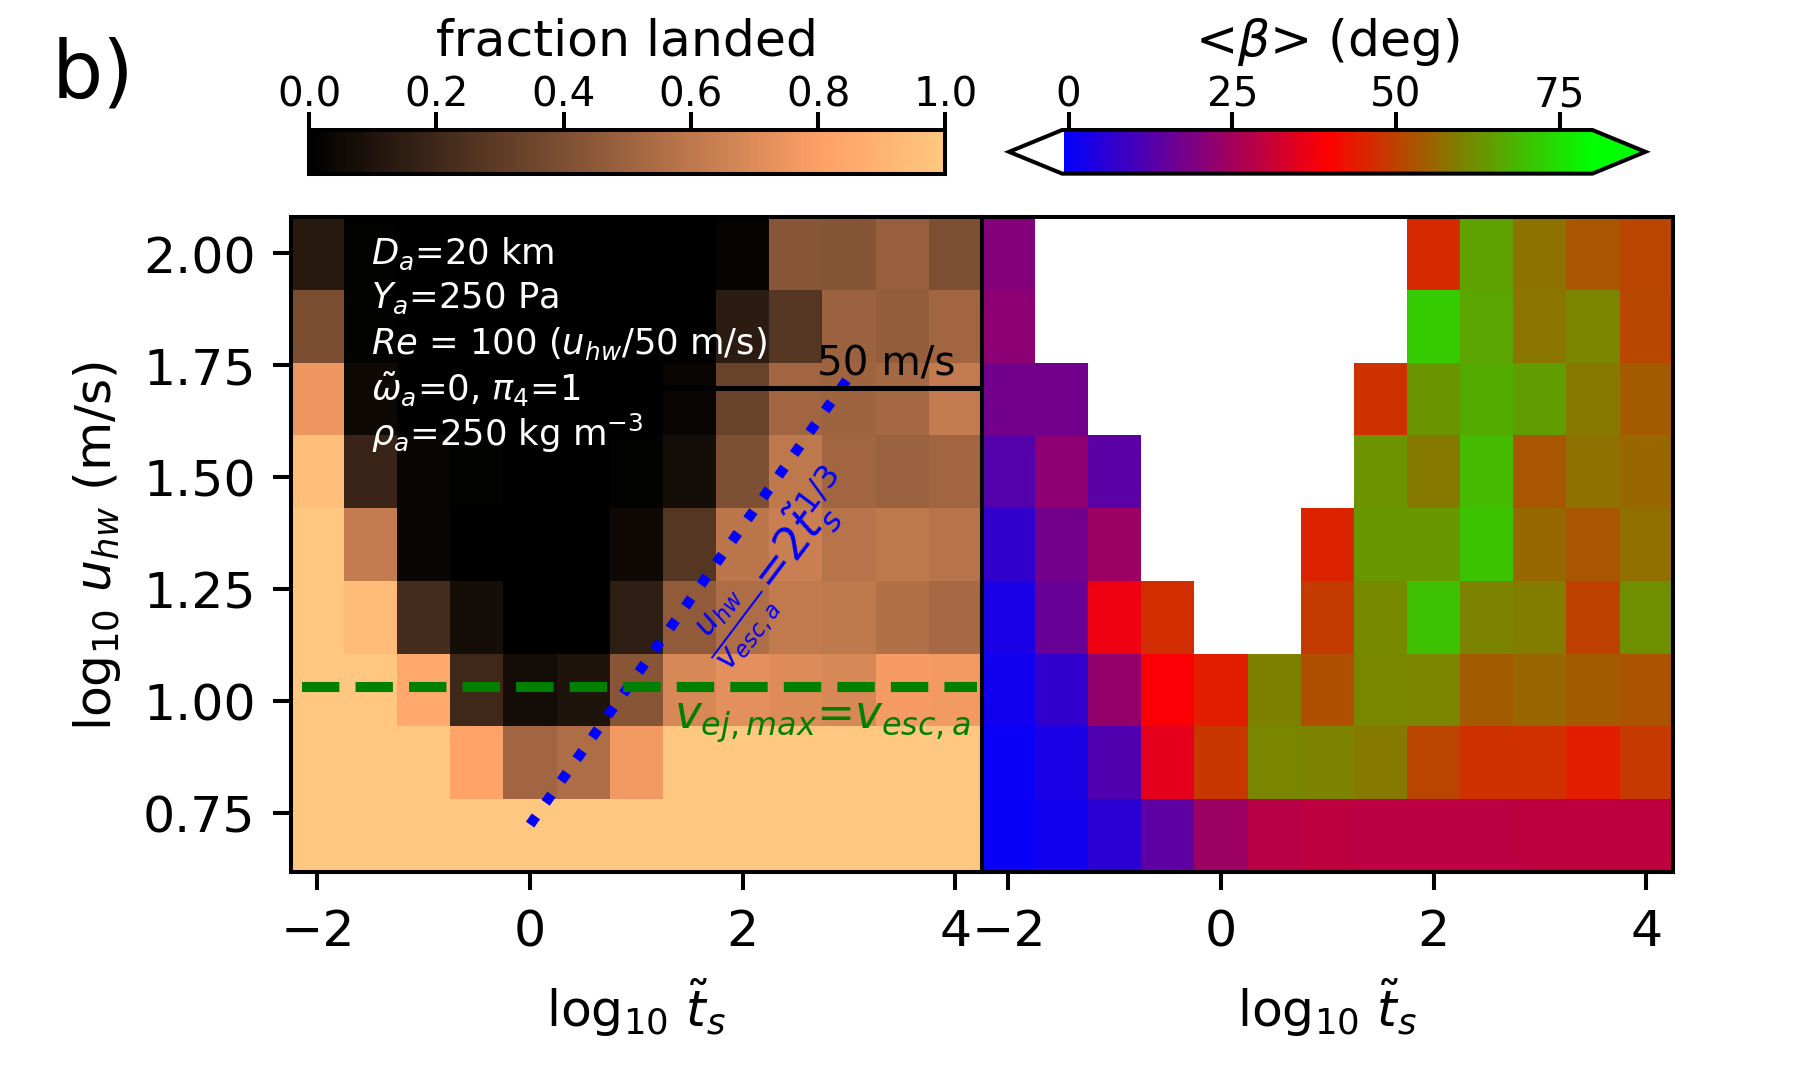

10.723155262762809


In [20]:
fig,axarr = plt.subplots(1,2,figsize=(5,3),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.16,right=0.92,top=0.80,bottom=0.2,hspace=0,wspace=0)
axarr[0].set_xlabel(r'log$_{10}$ $\tilde t_s$')
axarr[0].set_ylabel(r'log$_{10}$ $u_{hw}$ (m/s)')
axarr[1].set_xlabel(r'log$_{10}$ $\tilde t_s$')
axarr[1].set_yticks([])
cax1 = plt.axes((0.17, 0.84, 0.35, 0.04))
cax1.tick_params(labelsize=8,pad=-0.5)
cax2 = plt.axes((0.555, 0.84, 0.35, 0.04))
cax2.tick_params(labelsize=8,pad=-0.5)

im=axarr[0].pcolormesh(lt_h, lu_h,1-nesc_2D_h,shading='auto',cmap='copper',vmin=0,vmax=1)
cbar = plt.colorbar(im,cax = cax1, location='top')
cbar.set_label(label='fraction landed',size=10)
im2=axarr[1].pcolormesh(lt_h, lu_h,mean_dt_h*180/np.pi,shading='auto',cmap=newcmp,vmin=-1,vmax=80) 
cbar2=plt.colorbar(im2,extend='both',extendfrac=0.1,cax = cax2, location='top')
cbar2.set_label(label=r'<$\beta$> (deg)',size=10)

xll = -1.5
dz = 0.1; z0 = 1.6
lcolor='white'
axarr[0].text(xll,z0,r'$\rho_a$=250 kg m$^{-3}$',va='center',ha='left',fontsize=7,color=lcolor)
axarr[0].text(xll,z0+dz, r'$\tilde \omega_a$=0, $\pi_4$=1',va='center',ha='left',fontsize=7,color=lcolor)
axarr[0].text(xll,z0+dz*2, r'$Re$ = 100 ($u_{hw}$/50 m/s)',va='center',ha='left',fontsize=7,color=lcolor)
axarr[0].text(xll,z0+dz*3, r'$Y_{a}$=250 Pa',va='center',ha='left',fontsize=7,color=lcolor)
axarr[0].text(xll,z0+dz*4, r'$D_a$=20 km',va='center',ha='left',fontsize=7,color=lcolor)

tlin = np.linspace(0.0,3,10)  # log ts 
ts = 10**tlin
ulin = 2*v_a_fid*ts**0.333333 
lulin = np.log10(ulin)
# this relation is  u_hw/vescape ts**-1/3 = 2
# which is vesc/u_hw ts**1/3 = 0.5
axarr[0].text(1.45,1.1,r'$\frac{u_{hw}}{v_{esc,a}}$=2$\tilde t_s^{1/3}$',rotation=53,color='blue',fontsize=9)
axarr[0].plot(tlin,lulin,':',lw=2,color='blue')

uu = vesc_fid/(vmax_fid/tilde_uhw_fid)   # is 3.7/0.35
print(uu)
axarr[0].plot([-2.15,4.2],[np.log10(uu),np.log10(uu)],'g--',lw=2)  # 3.7 is v_esc for fiducial model
axarr[0].text(1.35,0.94,r'$v_{ej,max}$=$v_{esc,a}$',fontsize=9,color='green')

lu50 = np.log10(50.)
axarr[0].plot([0,4.2],[lu50,lu50],'k-',lw=1)  # 
axarr[0].text(2.7,lu50+0.03,'50 m/s',color='black',fontsize=8)

axarr[0].text(-4.5,2.35,'b)',fontsize=16)
plt.savefig('nesc_2D_luw.png',dpi=200)

In [85]:
# ts and Ya parm sweep
ts_arr = np.logspace(-2,4.0,13)  # stopping times (dimensionless)
Ya_arr = np.logspace(1.2,3.5,11)
print(Ya_arr,ts_arr)

Re = 100  # Reynold number of whole body
theta_s_deg = 45.  # in degrees 
theta_s = theta_s_deg*np.pi/180.0   # in radians 
tilde_Omega_a = 0.01
tilde_Omega_a_vec = np.array([np.sin(theta_s), 0.0, np.cos(theta_s)]) *tilde_Omega_a

dt = 0.005  # timestep
nc = 100   # number of particles integrated 
rho_a = 250. #mks
u_hw = 50.0 # m/s  # setting by hand 

ts_2D,Ya_2D = np.meshgrid(ts_arr,Ya_arr)  # X,Y
lt_e = np.log10(ts_2D)
lY_e = np.log10(Ya_2D)
nesc_2D_e = Ya_2D*0.0
mean_dt_e = Ya_2D*0.0
D_a_km = 20.0

for j in range(len(ts_arr)):
    print(j)
    for i in range(len(Ya_arr)):
        tilde_ts = ts_2D[i,j]
        Y_a = Ya_2D[i,j]
        print('ts,Ya',tilde_ts,Y_a)
        tilde_uhw,vmax,vmax_vmin_ratio,v_a = get_parms(D_a_km,rho_a,Y_a,u_hw)  # 
        dtheta_arr, nesc,theta_init_arr,theta_final_arr = \
            stats2(nc,tilde_Omega_a_vec,vmax,vmax_vmin_ratio,tilde_ts,tilde_uhw,Re,dt)
        nesc_2D_e[i,j] = nesc/nc
        kk = (dtheta_arr >= 0)  # is Boolean
        nk = len(dtheta_arr[kk])
        if (nk>1):
            mean_dt_e[i,j] = np.mean(dtheta_arr[kk])
        else:
            mean_dt_e[i,j] = -100  # false value here

[  15.84893192   26.91534804   45.70881896   77.62471166  131.82567386
  223.87211386  380.18939632  645.65422903 1096.47819614 1862.08713666
 3162.27766017] [1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00 3.16227766e+00 1.00000000e+01 3.16227766e+01
 1.00000000e+02 3.16227766e+02 1.00000000e+03 3.16227766e+03
 1.00000000e+04]
0
ts,Ya 0.01 15.848931924611133
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=2.5e-05
tilde_uhw=18.9, tilde_vmax=6.6, tilde_vmin=0.157, vmax_vmin_ratio=42.0
ts,Ya 0.01 26.915348039269155
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=4.3e-05
tilde_uhw=18.9, tilde_vmax=6.6, tilde_vmin=0.204, vmax_vmin_ratio=32.3
ts,Ya 0.01 45.708818961487495
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=7.3e-05
tilde_uhw=18.9, tilde_vmax=6.6, tilde_vmin=0.266, vmax_vmin_ratio=24.7
ts,Ya 0.01 77.62471166286916
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=1.2e-04
tilde_uhw=18.9, tilde_vmax=6.6, tilde_vmin=0.347, vmax_vmin_ratio=19.0
ts,Ya 0.01 13

ts,Ya 1.0 223.87211385683378
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=3.6e-04
tilde_uhw=18.9, tilde_vmax=6.6, tilde_vmin=0.590, vmax_vmin_ratio=11.2
ts,Ya 1.0 380.1893963205613
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=6.1e-04
tilde_uhw=18.9, tilde_vmax=6.6, tilde_vmin=0.768, vmax_vmin_ratio=8.6
ts,Ya 1.0 645.6542290346549
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=1.0e-03
tilde_uhw=18.9, tilde_vmax=6.6, tilde_vmin=1.001, vmax_vmin_ratio=6.6
ts,Ya 1.0 1096.4781961431852
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=1.8e-03
tilde_uhw=18.9, tilde_vmax=6.6, tilde_vmin=1.305, vmax_vmin_ratio=5.1
ts,Ya 1.0 1862.0871366628655
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=3.0e-03
tilde_uhw=18.9, tilde_vmax=6.6, tilde_vmin=1.701, vmax_vmin_ratio=3.9
ts,Ya 1.0 3162.2776601683795
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=5.1e-03
tilde_uhw=18.9, tilde_vmax=6.6, tilde_vmin=2.216, vmax_vmin_ratio=3.0
5
ts,Ya 3.1622776601683795 15.848931924611133
D_a_km=20.0 km, v_a=2.6 m

ts,Ya 316.22776601683796 26.915348039269155
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=4.3e-05
tilde_uhw=18.9, tilde_vmax=6.6, tilde_vmin=0.204, vmax_vmin_ratio=32.3
ts,Ya 316.22776601683796 45.708818961487495
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=7.3e-05
tilde_uhw=18.9, tilde_vmax=6.6, tilde_vmin=0.266, vmax_vmin_ratio=24.7
ts,Ya 316.22776601683796 77.62471166286916
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=1.2e-04
tilde_uhw=18.9, tilde_vmax=6.6, tilde_vmin=0.347, vmax_vmin_ratio=19.0
ts,Ya 316.22776601683796 131.82567385564073
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=2.1e-04
tilde_uhw=18.9, tilde_vmax=6.6, tilde_vmin=0.453, vmax_vmin_ratio=14.6
ts,Ya 316.22776601683796 223.87211385683378
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=3.6e-04
tilde_uhw=18.9, tilde_vmax=6.6, tilde_vmin=0.590, vmax_vmin_ratio=11.2
ts,Ya 316.22776601683796 380.1893963205613
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=6.1e-04
tilde_uhw=18.9, tilde_vmax=6.6, tilde_vmin=0.76

<IPython.core.display.Javascript object>


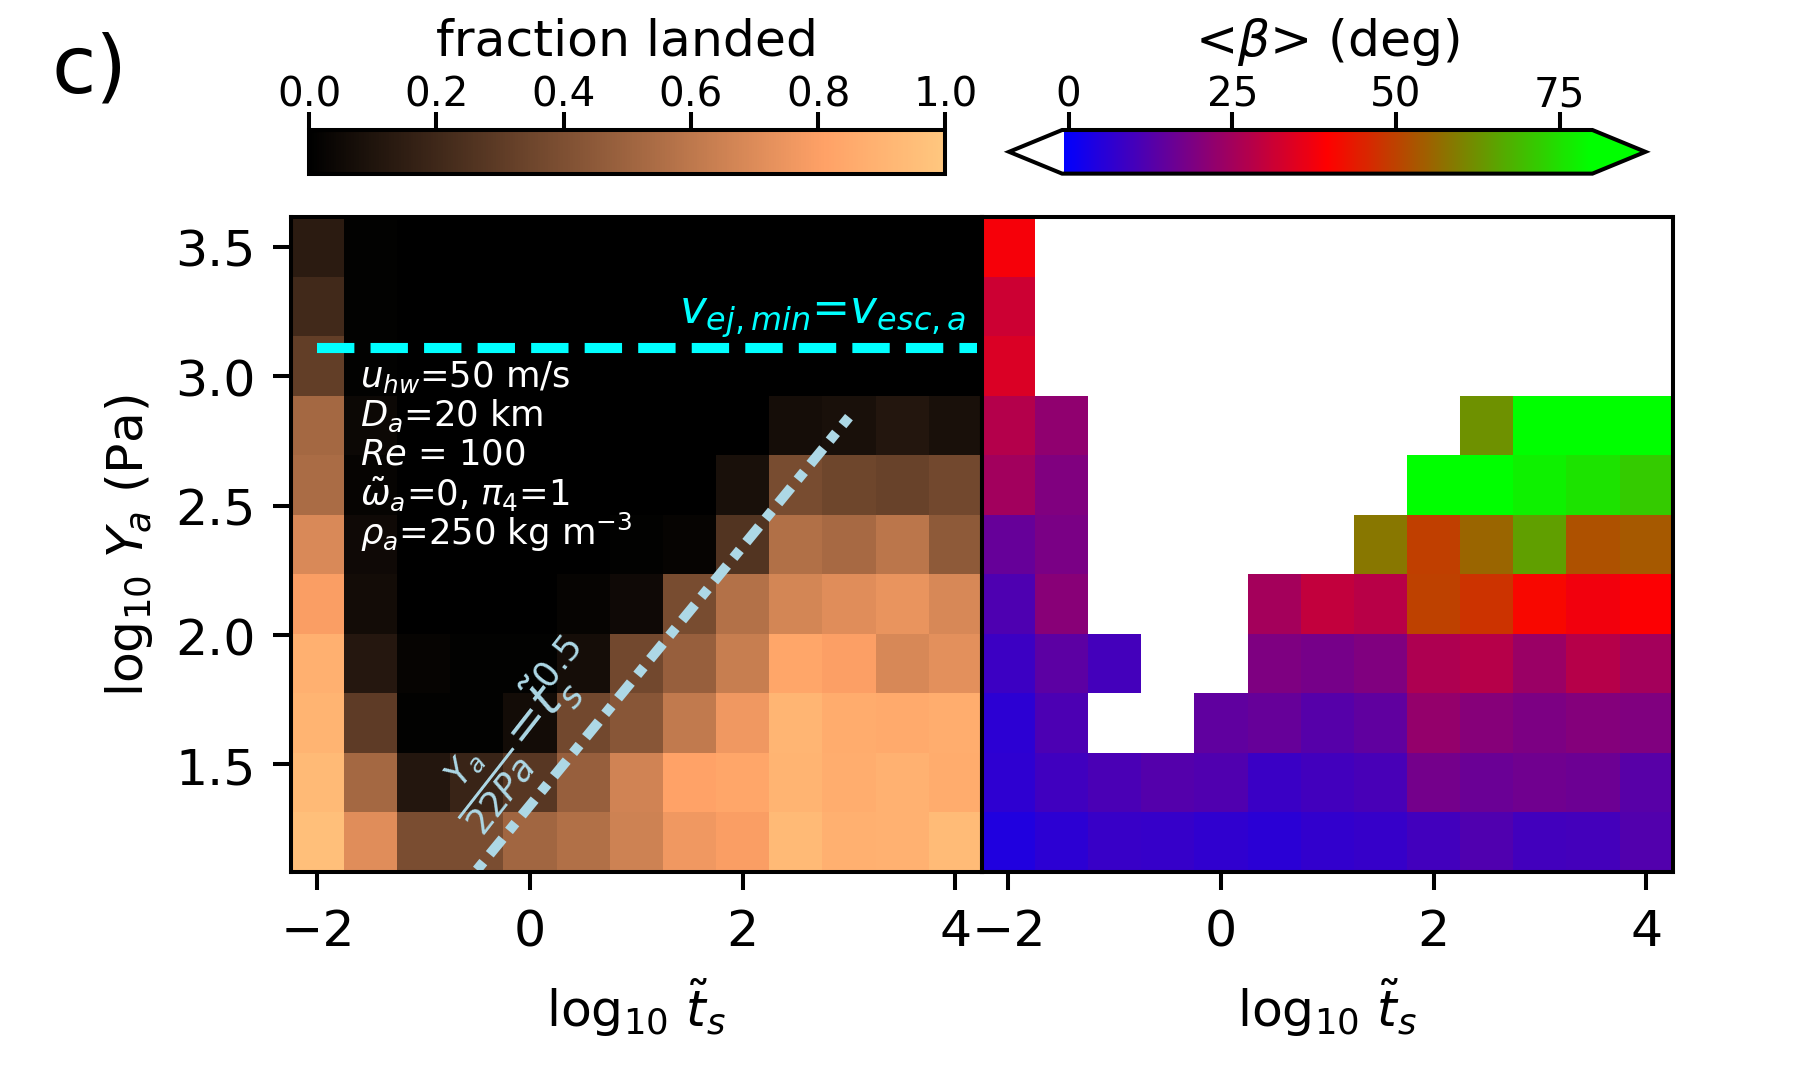

3.1097829043134766


In [304]:
fig,axarr = plt.subplots(1,2,figsize=(5,3),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.16,right=0.92,top=0.80,bottom=0.2,hspace=0,wspace=0)
axarr[0].set_xlabel(r'log$_{10}$ $\tilde t_s$')
axarr[0].set_ylabel(r'log$_{10}$ $Y_{\!a}$ (Pa)')
axarr[1].set_xlabel(r'log$_{10}$ $\tilde t_s$')
axarr[1].set_yticks([])
cax1 = plt.axes((0.17, 0.84, 0.35, 0.04))
cax1.tick_params(labelsize=8,pad=-0.5)
cax2 = plt.axes((0.555, 0.84, 0.35, 0.04))
cax2.tick_params(labelsize=8,pad=-0.5)

im=axarr[0].pcolormesh(lt_e, lY_e,1-nesc_2D_e,shading='auto',cmap='copper',vmin=0,vmax=1)
cbar = plt.colorbar(im,cax = cax1, location='top')
cbar.set_label(label='fraction landed',size=10)
im2=axarr[1].pcolormesh(lt_e, lY_e,mean_dt_e*180/np.pi,shading='auto',cmap=newcmp,vmin=-1,vmax=80) 
cbar2=plt.colorbar(im2,extend='both',extendfrac=0.1,cax = cax2, location='top')
cbar2.set_label(label=r'<$\beta$> (deg)',size=10)

xll = -1.6
z0 = 2.4; dz = 0.15
lcolor='white'
axarr[0].text(xll,z0,r'$\rho_a$=250 kg m$^{-3}$',va='center',ha='left',fontsize=7,color=lcolor)
axarr[0].text(xll,z0+dz, r'$\tilde \omega_a$=0, $\pi_4$=1',va='center',ha='left',fontsize=7,color=lcolor)
axarr[0].text(xll,z0+dz*2, r'$Re$ = 100',va='center',ha='left',fontsize=7,color=lcolor)
axarr[0].text(xll,z0+dz*3, r'$D_a$=20 km',va='center',ha='left',fontsize=7,color=lcolor)
axarr[0].text(xll,z0+dz*4, r'$u_{hw}$=50 m/s',va='center',ha='left',fontsize=7,color=lcolor)


# recall that tilde_vmin_fid is for Y_a = 250 and tidle_vmin propto Ya^1/2
# tilde_vmin_fid * v_a_fid  = vmin in physical units
# tilde_vmin_fid * v_a_fid / (v_a_fid*sqrt(2)) is equal to v_min_fid/vesc_fid 
# tilde_vmin_fid /sqrt(2)) is equal to v_min_fid/vesc_fid and is propto Ya_fid^1/2
# vmin/vesc = tilde_vmin_fid/sqrt(2) (Ya/Ya_fid)^1/2
# vmin/vesc = 1 when    Ya = Ya_fid * 2/tilde_vmin^2
Ycond = Y_a_fid*2/tilde_vmin_fid**2
lYcond = np.log10(Ycond)
print(lYcond)
axarr[0].plot([-2,4.2],[lYcond,lYcond],'--',color='cyan',lw=2) #
axarr[0].text(1.4,lYcond+0.1,r'$v_{ej,min}$=$v_{esc,a}$',fontsize=9,color='cyan')


tlin = np.linspace(-0.5,2.2,10)
ts = 10**tlin
# vmin/vesc = tilde_vmin_fid/sqrt(2) (Ya/Ya_fid)^1/2, from above
# try (vmin/vesc)^k = A*ts 
#  (vmin/vesc)  = (A ts)^(1/k)
# tilde_vmin_fid/sqrt(2) (Ya/Ya_fid)^0.5  = (A ts)^(1/k)
# tilde_vmin_fid^2/2 Ya/Ya_fid = (A*ts)^(2/k) 
# Ya = Ya_fid 2 tilde_vmin_fid^(-2) * (A*ts)^(2/k)
kk = 4
AA = 1e-3
Yalin = Y_a_fid * 2 * tilde_vmin_fid**-2 *(AA*ts)**(2.0/kk)
lYalin = np.log10(Yalin)
#axarr[0].plot(tlin,lYalin,lw=2,color='lightblue',ls = (0,(1,1,2,1)))

tlin = np.linspace(-0.5,3.0,10)
ts = 10**tlin
Yalin = ts**0.5 * 22.0
lYalin = np.log10(Yalin)
axarr[0].plot(tlin,lYalin,lw=2,color='lightblue',ls = (0,(1,1,2,1)))
# (Y_a/10^1.25) = tilde t**0.4 is the curve 
axarr[0].text(-1,1.3,r'$\frac{Y_a}{22 Pa}$=$\tilde t_s^{0.5}$',rotation=52,color='lightblue')


axarr[0].text(-4.5,4.1,'c)',fontsize=16)
plt.savefig('nesc_2D_Ya.png',dpi=200)

In [67]:
# parm sweep ts and uhw
ts_arr = np.logspace(-2,4.0,13)  # stopping times (dimensionless)
u_fac = np.linspace(0.08,1,9)  #0.1 to 1 times u_hw
print(u_fac,ts_arr)

Re_1 = 100  # Reynold number of whole body
theta_s_deg = 45.  # in degrees 
theta_s = theta_s_deg*np.pi/180.0   # in radians 
tilde_Omega_a = 0.001
tilde_Omega_a_vec = np.array([np.sin(theta_s), 0.0, np.cos(theta_s)]) *tilde_Omega_a
dt = 0.005  # timestep
nc = 100   # number of particles integrated 
rho_a = 250. #mks
u_hw = 50.0 # m/s  # setting by hand,  just used for scaling here
Y_a = 250.0

ts_2D,u_2D = np.meshgrid(ts_arr,u_fac)  # X,Y
lt_c = np.log10(ts_2D)

nesc_2D_c = u_2D*0.0
mean_dt_c = u_2D*0.0

D_a_km = 20.0
for j in range(len(ts_arr)):
    print(j)
    for i in range(len(u_fac)):
        uf = u_2D[i,j]
        Re = Re_1*uf  # adjusting Re
        tilde_ts = ts_2D[i,j]
        print('ts,uf',tilde_ts,uf)
        tilde_uhw,vmax,vmax_vmin_ratio,v_a = get_parms(D_a_km,rho_a,Y_a,u_hw*uf)  # adjusting u_hw
        dtheta_arr, nesc,theta_init_arr,theta_final_arr = \
            stats2(nc,tilde_Omega_a_vec,vmax,vmax_vmin_ratio,tilde_ts,tilde_uhw,Re,dt)
        nesc_2D_c[i,j] = nesc/nc
        kk = (dtheta_arr >= 0)  # is Boolean
        nk = len(dtheta_arr[kk])
        if (nk>1):
            mean_dt_c[i,j] = np.mean(dtheta_arr[kk])
        else:
            mean_dt_c[i,j] = -100  # false value here

[0.08  0.195 0.31  0.425 0.54  0.655 0.77  0.885 1.   ] [1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00 3.16227766e+00 1.00000000e+01 3.16227766e+01
 1.00000000e+02 3.16227766e+02 1.00000000e+03 3.16227766e+03
 1.00000000e+04]
0
ts,uf 0.01 0.08
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=6.2e-02
tilde_uhw=1.5, tilde_vmax=0.5, tilde_vmin=0.623, vmax_vmin_ratio=0.8
ts,uf 0.01 0.195
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=1.1e-02
tilde_uhw=3.7, tilde_vmax=1.3, tilde_vmin=0.623, vmax_vmin_ratio=2.1
ts,uf 0.01 0.31
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=4.2e-03
tilde_uhw=5.9, tilde_vmax=2.0, tilde_vmin=0.623, vmax_vmin_ratio=3.3
ts,uf 0.01 0.42500000000000004
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=2.2e-03
tilde_uhw=8.0, tilde_vmax=2.8, tilde_vmin=0.623, vmax_vmin_ratio=4.5
ts,uf 0.01 0.54
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=1.4e-03
tilde_uhw=10.2, tilde_vmax=3.6, tilde_vmin=0.623, vmax_vmin_ratio=5.7
ts,uf 0.01 0.655
D_a

ts,uf 3.1622776601683795 1.0
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=4.0e-04
tilde_uhw=18.9, tilde_vmax=6.6, tilde_vmin=0.623, vmax_vmin_ratio=10.6
6
ts,uf 10.0 0.08
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=6.2e-02
tilde_uhw=1.5, tilde_vmax=0.5, tilde_vmin=0.623, vmax_vmin_ratio=0.8
ts,uf 10.0 0.195
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=1.1e-02
tilde_uhw=3.7, tilde_vmax=1.3, tilde_vmin=0.623, vmax_vmin_ratio=2.1
ts,uf 10.0 0.31
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=4.2e-03
tilde_uhw=5.9, tilde_vmax=2.0, tilde_vmin=0.623, vmax_vmin_ratio=3.3
ts,uf 10.0 0.42500000000000004
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=2.2e-03
tilde_uhw=8.0, tilde_vmax=2.8, tilde_vmin=0.623, vmax_vmin_ratio=4.5
ts,uf 10.0 0.54
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=1.4e-03
tilde_uhw=10.2, tilde_vmax=3.6, tilde_vmin=0.623, vmax_vmin_ratio=5.7
ts,uf 10.0 0.655
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=9.3e-04
tilde_uhw=12.4, tilde_vmax=4.3, tilde_vmin=0.62

12
ts,uf 10000.0 0.08
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=6.2e-02
tilde_uhw=1.5, tilde_vmax=0.5, tilde_vmin=0.623, vmax_vmin_ratio=0.8
ts,uf 10000.0 0.195
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=1.1e-02
tilde_uhw=3.7, tilde_vmax=1.3, tilde_vmin=0.623, vmax_vmin_ratio=2.1
ts,uf 10000.0 0.31
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=4.2e-03
tilde_uhw=5.9, tilde_vmax=2.0, tilde_vmin=0.623, vmax_vmin_ratio=3.3
ts,uf 10000.0 0.42500000000000004
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=2.2e-03
tilde_uhw=8.0, tilde_vmax=2.8, tilde_vmin=0.623, vmax_vmin_ratio=4.5
ts,uf 10000.0 0.54
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=1.4e-03
tilde_uhw=10.2, tilde_vmax=3.6, tilde_vmin=0.623, vmax_vmin_ratio=5.7
ts,uf 10000.0 0.655
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=9.3e-04
tilde_uhw=12.4, tilde_vmax=4.3, tilde_vmin=0.623, vmax_vmin_ratio=6.9
ts,uf 10000.0 0.77
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=6.7e-04
tilde_uhw=14.6, tilde_vmax=5.1, tilde_v

<IPython.core.display.Javascript object>


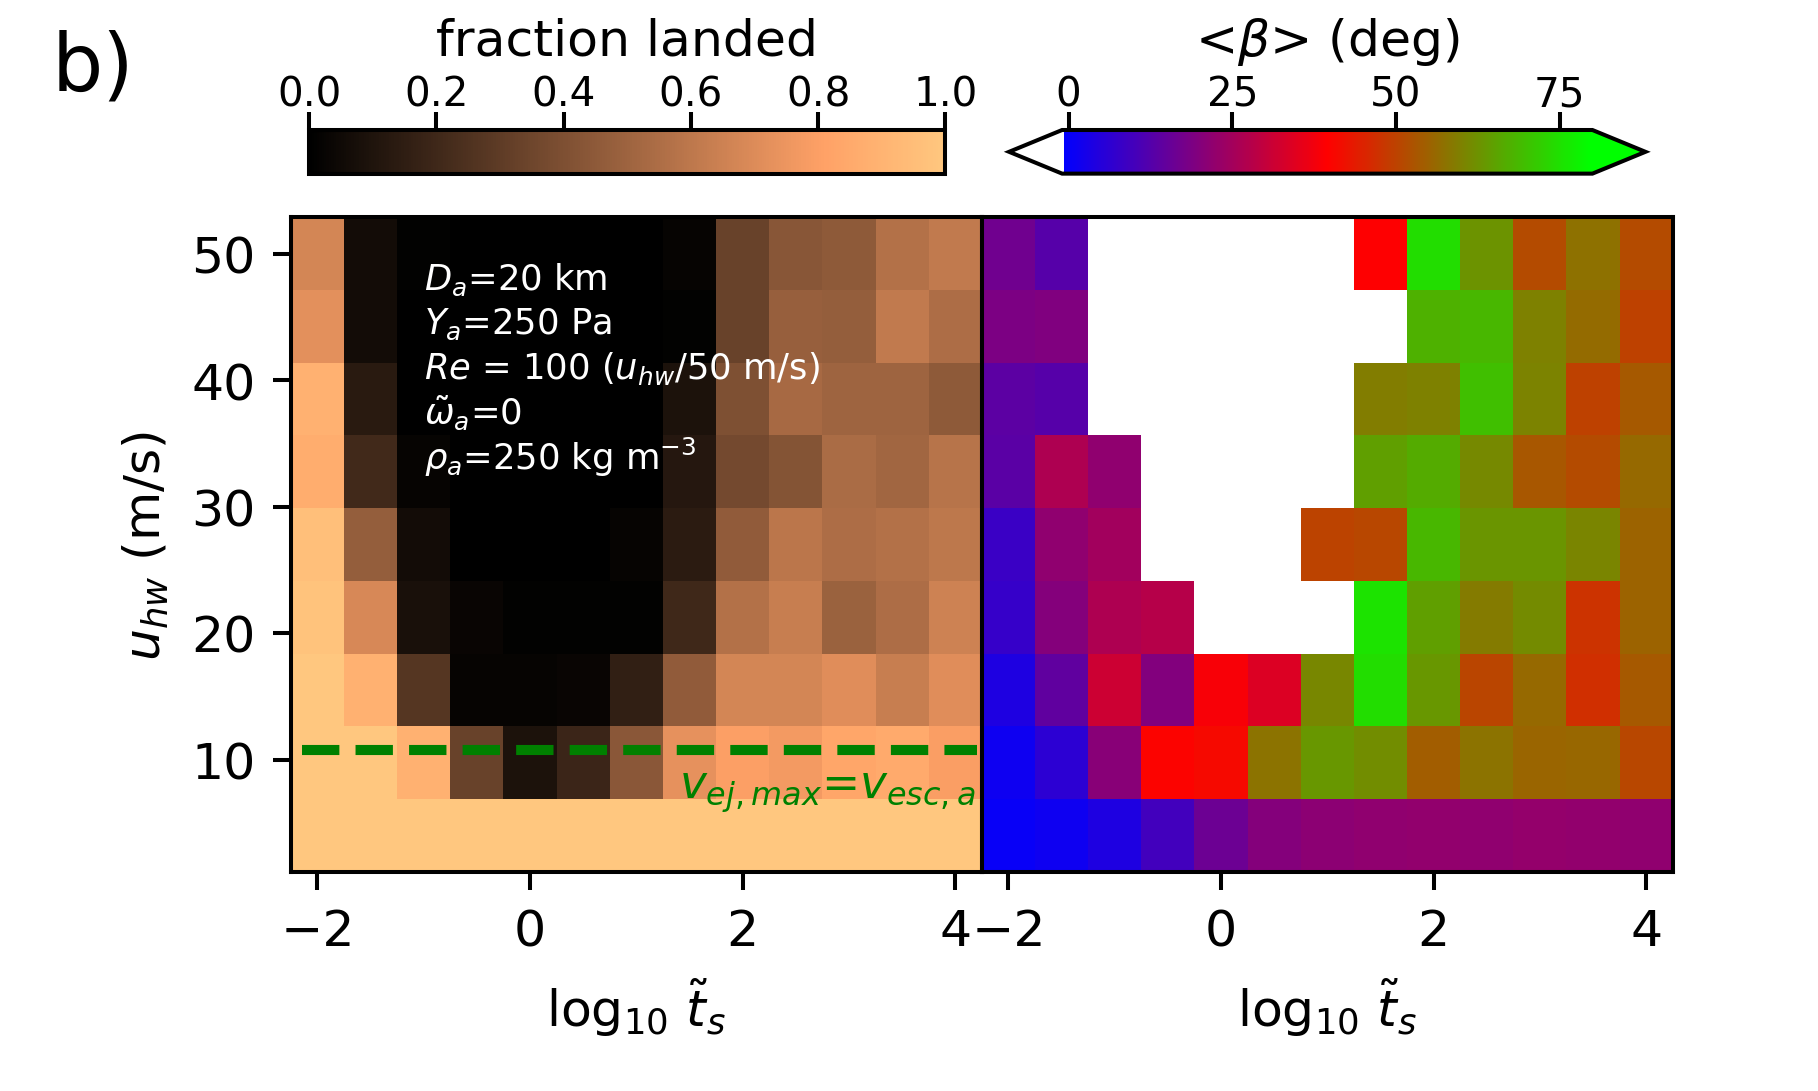

10.723155262762809


In [177]:
fig,axarr = plt.subplots(1,2,figsize=(5,3),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.16,right=0.92,top=0.80,bottom=0.2,hspace=0,wspace=0)
axarr[0].set_xlabel(r'log$_{10}$ $\tilde t_s$')
axarr[0].set_ylabel(r'$u_{hw}$ (m/s)')
axarr[1].set_xlabel(r'log$_{10}$ $\tilde t_s$')
axarr[1].set_yticks([])
cax1 = plt.axes((0.17, 0.84, 0.35, 0.04))
cax1.tick_params(labelsize=8,pad=-0.5)
cax2 = plt.axes((0.555, 0.84, 0.35, 0.04))
cax2.tick_params(labelsize=8,pad=-0.5)

im=axarr[0].pcolormesh(lt_c, u_2D*u_hw,1-nesc_2D_c,shading='auto',cmap='copper',vmin=0,vmax=1)
cbar = plt.colorbar(im,cax = cax1, location='top')
cbar.set_label(label='fraction landed',size=10)
im2=axarr[1].pcolormesh(lt_c, u_2D*u_hw,mean_dt_c*180/np.pi,shading='auto',cmap=newcmp,vmin=-1,vmax=80) 
cbar2=plt.colorbar(im2,extend='both',extendfrac=0.1,cax = cax2, location='top')
cbar2.set_label(label=r'<$\beta$> (deg)',size=10)

xll = -1
dz = 3.5; z0 = 34
lcolor='white'
axarr[0].text(xll,z0,r'$\rho_a$=250 kg m$^{-3}$',va='center',ha='left',fontsize=7,color=lcolor)
axarr[0].text(xll,z0+dz, r'$\tilde \omega_a$=0',va='center',ha='left',fontsize=7,color=lcolor)
axarr[0].text(xll,z0+dz*2, r'$Re$ = 100 ($u_{hw}$/50 m/s)',va='center',ha='left',fontsize=7,color=lcolor)
axarr[0].text(xll,z0+dz*3, r'$Y_{a}$=250 Pa',va='center',ha='left',fontsize=7,color=lcolor)
axarr[0].text(xll,z0+dz*4, r'$D_a$=20 km',va='center',ha='left',fontsize=7,color=lcolor)

#axarr[0].plot([-2.15,4.2],[3.7,3.7],'r:',lw=2)  # 3.7 is v_esc for fiducial model
#axarr[0].text(-2,5,r'$u_{hw}$=$v_{esc}$',fontsize=9,color='red')

uu = vesc_fid/(vmax_fid/tilde_uhw_fid)   # is 3.7/0.35
print(uu)
axarr[0].plot([-2.15,4.2],[uu,uu],'g--',lw=2)  # 3.7 is v_esc for fiducial model
axarr[0].text(1.4,7,r'$v_{ej,max}$=$v_{esc,a}$',fontsize=9,color='green')

axarr[0].text(-4.5,63,'b)',fontsize=16)
plt.savefig('nesc_2D_uw.png',dpi=200)

<IPython.core.display.Javascript object>


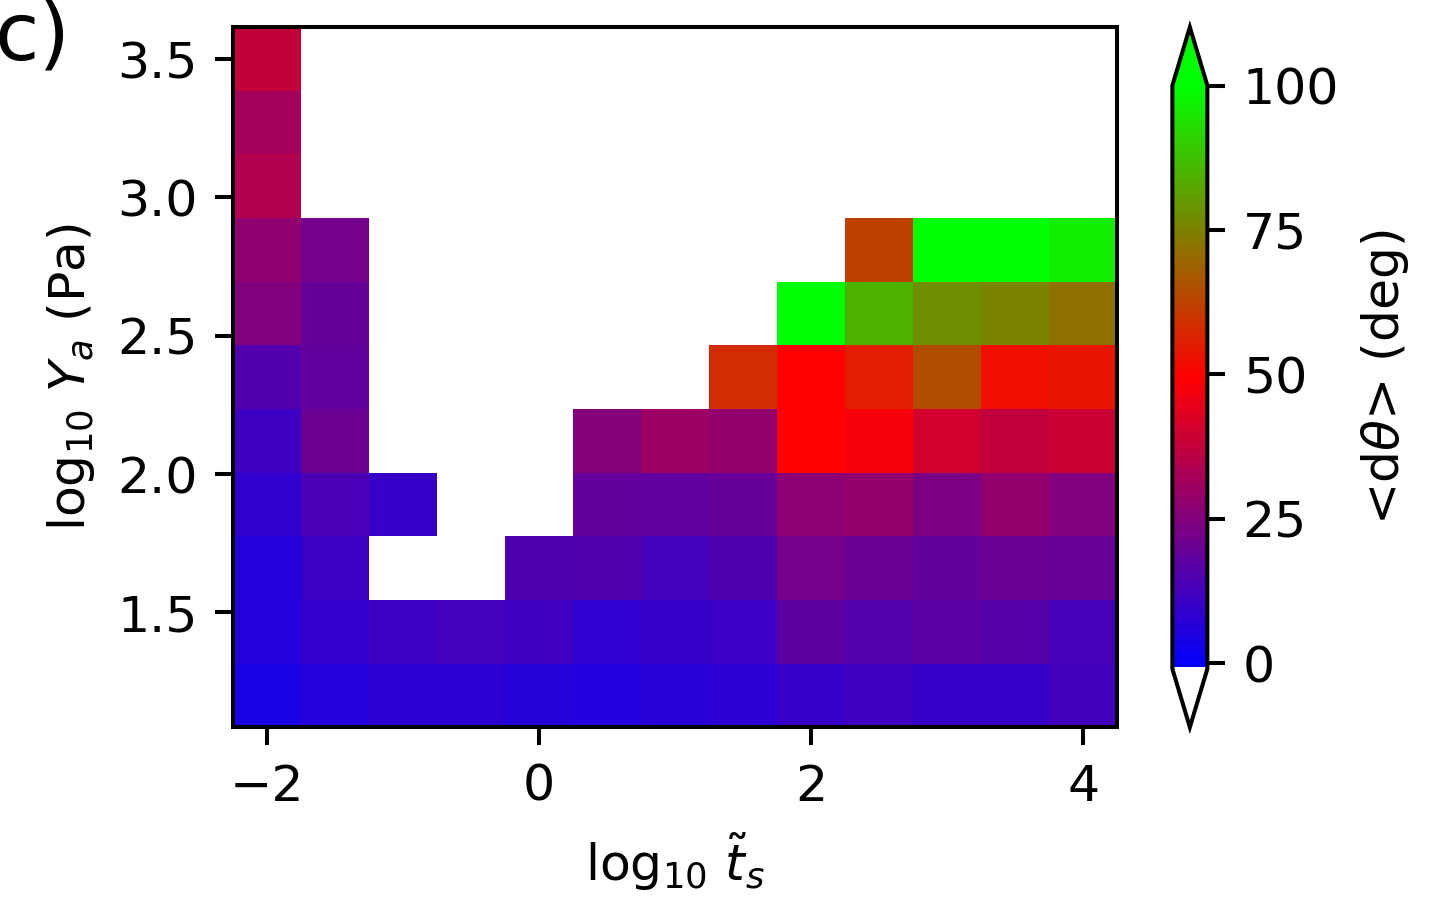

In [116]:
# figure xxx , plot previous <d theta> instead
fig,ax = plt.subplots(1,1,figsize=(4,2.5),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.16,right=0.92,top=0.97,bottom=0.2)

im=ax.pcolormesh(lt_e, lY_e,mean_dt_e*180/np.pi,shading='auto',cmap=newcmp,vmin=-1,vmax=100) # ,vmin=0,vmax=1)
plt.colorbar(im,label=r'<d$\theta$> (deg)',extend='both',extendfrac=0.1)
ax.set_xlabel(r'log$_{10}$ $\tilde t_s$')
ax.set_ylabel(r'log$_{10}$ $Y_a$ (Pa)')

ax.text(-4.0,3.5,'c)',fontsize=16)
plt.savefig('dtheta_2D_Ya.png',dpi=200)

In [99]:
# parm sweep ts and Re
ts_arr = np.logspace(-2,4.0,13)  # stopping times (dimensionless)
Re_arr = np.logspace(1,5,8)
print(Re_arr,ts_arr)

#Re = 1e6  # Reynold number of whole body
theta_s_deg = 45.  # in degrees 
theta_s = theta_s_deg*np.pi/180.0   # in radians 
tilde_Omega_a = 0.001
tilde_Omega_a_vec = np.array([np.sin(theta_s), 0.0, np.cos(theta_s)]) *tilde_Omega_a
dt = 0.005  # timestep
nc = 100   # number of particles integrated 
rho_a = 250. #mks
u_hw = 50.0 # m/s  # setting by hand 
Y_a = 250.0

ts_2D,Re_2D = np.meshgrid(ts_arr,Re_arr)  # X,Y
lt_b = np.log10(ts_2D)
lR_b = np.log10(Re_2D)

nesc_2D_b = Re_2D*0.0
mean_dt_b = Re_2D*0.0

D_a_km = 20.0
tilde_uhw,vmax,vmax_vmin_ratio,v_a = get_parms(D_a_km,rho_a,Y_a,u_hw)
for j in range(len(ts_arr)):
    print(j)
    for i in range(len(Re_arr)):
        Re = Re_2D[i,j]
        tilde_ts = ts_2D[i,j]
        print('ts,Re',tilde_ts,D_a_km)
        dtheta_arr, nesc,theta_init_arr,theta_final_arr = \
            stats2(nc,tilde_Omega_a_vec,vmax,vmax_vmin_ratio,tilde_ts,tilde_uhw,Re,dt)
        nesc_2D_b[i,j] = nesc/nc
        kk = (dtheta_arr >= 0)  # is Boolean
        nk = len(dtheta_arr[kk])
        if (nk>1):
            mean_dt_b[i,j] = np.mean(dtheta_arr[kk])
        else:
            mean_dt_b[i,j] = -100  # false value here

[1.00000000e+01 3.72759372e+01 1.38949549e+02 5.17947468e+02
 1.93069773e+03 7.19685673e+03 2.68269580e+04 1.00000000e+05] [1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00 3.16227766e+00 1.00000000e+01 3.16227766e+01
 1.00000000e+02 3.16227766e+02 1.00000000e+03 3.16227766e+03
 1.00000000e+04]
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=4.0e-04
tilde_uhw=18.9, tilde_vmax=6.6, tilde_vmin=0.623, vmax_vmin_ratio=10.6
0
ts,Re 0.01 20.0
ts,Re 0.01 20.0
ts,Re 0.01 20.0
ts,Re 0.01 20.0
ts,Re 0.01 20.0
ts,Re 0.01 20.0
ts,Re 0.01 20.0
ts,Re 0.01 20.0
1
ts,Re 0.03162277660168379 20.0
ts,Re 0.03162277660168379 20.0
ts,Re 0.03162277660168379 20.0
ts,Re 0.03162277660168379 20.0
ts,Re 0.03162277660168379 20.0
ts,Re 0.03162277660168379 20.0
ts,Re 0.03162277660168379 20.0
ts,Re 0.03162277660168379 20.0
2
ts,Re 0.1 20.0
ts,Re 0.1 20.0
ts,Re 0.1 20.0
ts,Re 0.1 20.0
ts,Re 0.1 20.0
ts,Re 0.1 20.0
ts,Re 0.1 20.0
ts,Re 0.1 20.0
3
ts,Re 0.31622776601683794 20.0
ts,Re 0.3162277

<IPython.core.display.Javascript object>


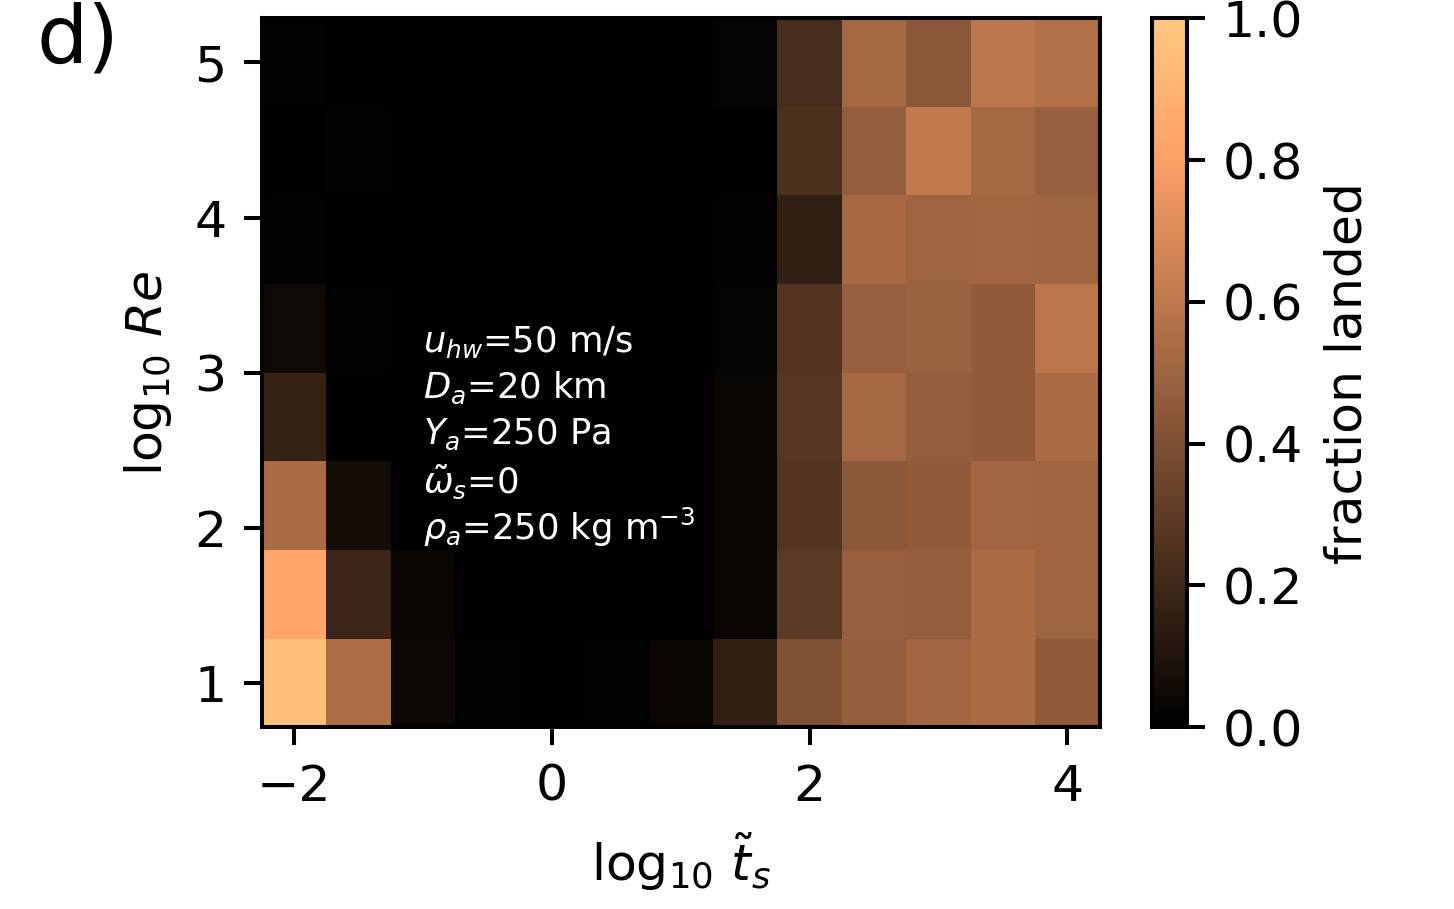

In [103]:
fig,ax = plt.subplots(1,1,figsize=(4,2.5),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.18,right=0.90,top=0.98,bottom=0.2)

im=ax.pcolormesh(lt_b, lR_b,1-nesc_2D_b,shading='auto',cmap='copper',vmin=0,vmax=1)
plt.colorbar(im,label='fraction landed')
ax.set_xlabel(r'log$_{10}$ $\tilde t_s$')
ax.set_ylabel(r'log$_{10}$ $Re$')
xll = -1.
dz = 0.3; y0=2
lcolor='white'
ax.text(xll,y0,r'$\rho_a$=250 kg m$^{-3}$',va='center',ha='left',fontsize=7,color=lcolor)
ax.text(xll,y0+dz, r'$\tilde \omega_s$=0',va='center',ha='left',fontsize=7,color=lcolor)
ax.text(xll,y0+dz*2, r'$Y_{a}$=250 Pa',va='center',ha='left',fontsize=7,color=lcolor)
ax.text(xll,y0+dz*3, r'$D_a$=20 km',va='center',ha='left',fontsize=7,color=lcolor)
ax.text(xll,y0+dz*4, r'$u_{hw}$=50 m/s',va='center',ha='left',fontsize=7,color=lcolor)

ax.text(-4.0,5,'d)',fontsize=16)
plt.savefig('nesc_2D_Re.png',dpi=200)

<IPython.core.display.Javascript object>


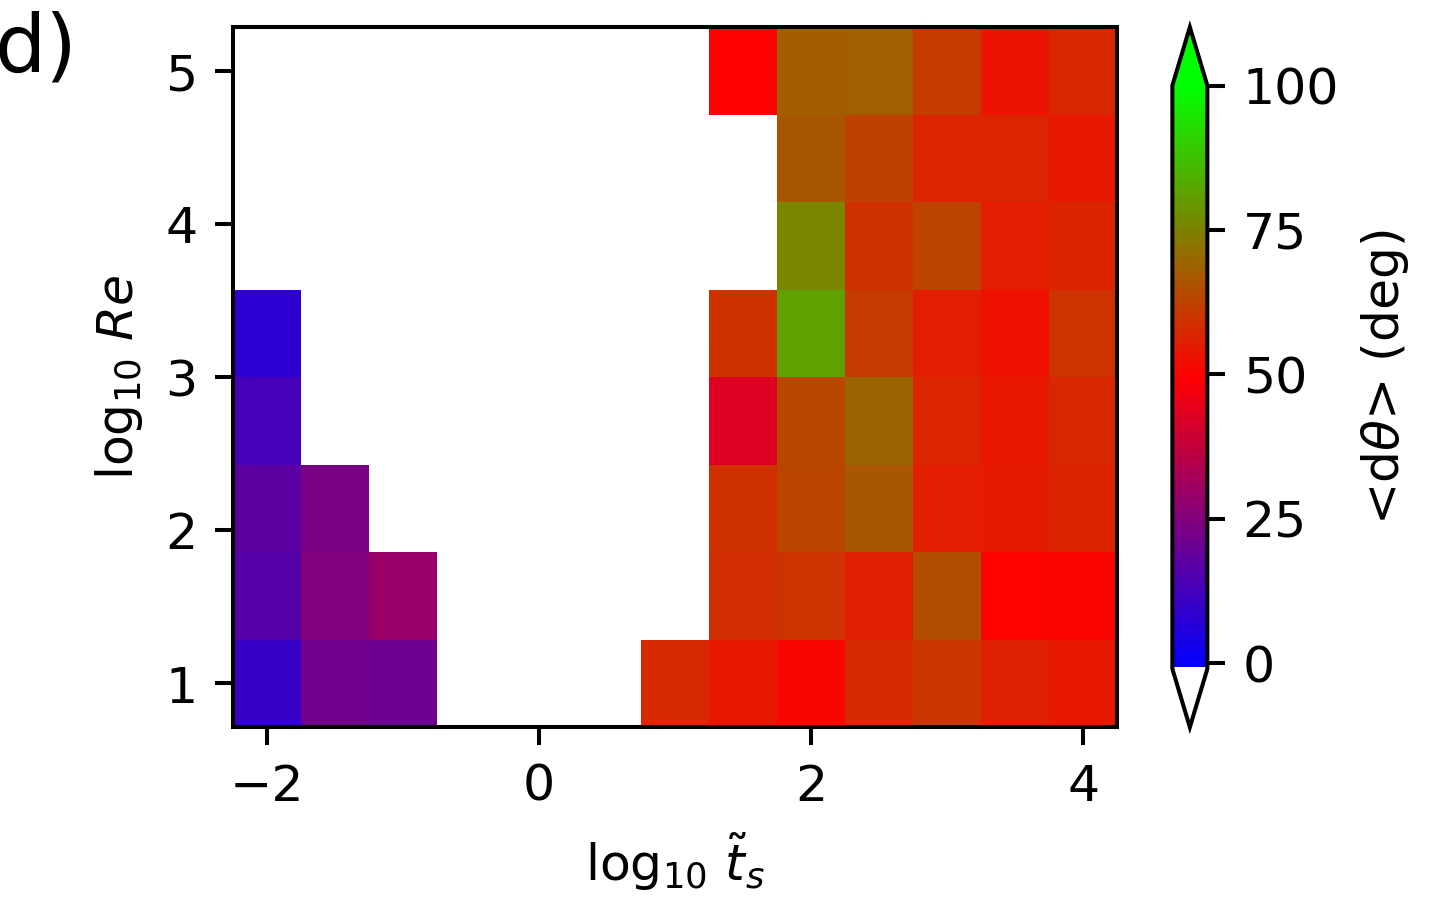

In [118]:
# figure xxx , plot previous <d theta> instead
fig,ax = plt.subplots(1,1,figsize=(4,2.5),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.16,right=0.92,top=0.97,bottom=0.2)

im=ax.pcolormesh(lt_b, lR_b,mean_dt_b*180/np.pi,shading='auto',cmap=newcmp,vmin=-1,vmax=100) # ,vmin=0,vmax=1)
plt.colorbar(im,label=r'<d$\theta$> (deg)',extend='both',extendfrac=0.1)
ax.set_xlabel(r'log$_{10}$ $\tilde t_s$')
ax.set_ylabel(r'log$_{10}$ $Re$')

ax.text(-4.0,5,'d)',fontsize=16)
plt.savefig('dtheta_2D_Re.png',dpi=200)

In [105]:
# parm sweep ts and tilde omega
ts_arr = np.logspace(-2,4.0,13)  # stopping times (dimensionless)
om_fac = np.linspace(0.1,1.2,8)
print(om_fac,ts_arr)

Re = 100  # Reynold number of whole body
theta_s_deg = 45.  # in degrees 
theta_s = theta_s_deg*np.pi/180.0   # in radians 

dt = 0.005  # timestep
nc = 100   # number of particles integrated 
rho_a = 250. #mks
u_hw = 50.0 # m/s  # setting by hand 
Y_a = 250.0

ts_2D,om_2D = np.meshgrid(ts_arr,om_fac)  # X,Y
lt_d = np.log10(ts_2D)
nesc_2D_d = om_2D*0.0
mean_dt_d = om_2D*0.0
D_a_km = 20.0
tilde_uhw,vmax,vmax_vmin_ratio,v_a = get_parms(D_a_km,rho_a,Y_a,u_hw)  # 
for j in range(len(ts_arr)):
    print(j)
    for i in range(len(om_fac)):
        tilde_Omega_a = om_2D[i,j]
        tilde_Omega_a_vec = np.array([np.sin(theta_s), 0.0, np.cos(theta_s)]) *tilde_Omega_a
        tilde_ts = ts_2D[i,j]
        print('ts,tom',tilde_ts,tilde_Omega_a)
        dtheta_arr, nesc,theta_init_arr,theta_final_arr = \
            stats2(nc,tilde_Omega_a_vec,vmax,vmax_vmin_ratio,tilde_ts,tilde_uhw,Re,dt)
        nesc_2D_d[i,j] = nesc/nc
        kk = (dtheta_arr >= 0)  # is Boolean
        nk = len(dtheta_arr[kk])
        if (nk>1):
            mean_dt_d[i,j] = np.mean(dtheta_arr[kk])
        else:
            mean_dt_d[i,j] = -100  # false value here
        

[0.1        0.25714286 0.41428571 0.57142857 0.72857143 0.88571429
 1.04285714 1.2       ] [1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00 3.16227766e+00 1.00000000e+01 3.16227766e+01
 1.00000000e+02 3.16227766e+02 1.00000000e+03 3.16227766e+03
 1.00000000e+04]
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=4.0e-04
tilde_uhw=18.9, tilde_vmax=6.6, tilde_vmin=0.623, vmax_vmin_ratio=10.6
0
ts,tom 0.01 0.1
ts,tom 0.01 0.2571428571428571
ts,tom 0.01 0.41428571428571426
ts,tom 0.01 0.5714285714285713
ts,tom 0.01 0.7285714285714284
ts,tom 0.01 0.8857142857142856
ts,tom 0.01 1.0428571428571427
ts,tom 0.01 1.2
1
ts,tom 0.03162277660168379 0.1
ts,tom 0.03162277660168379 0.2571428571428571
ts,tom 0.03162277660168379 0.41428571428571426
ts,tom 0.03162277660168379 0.5714285714285713
ts,tom 0.03162277660168379 0.7285714285714284
ts,tom 0.03162277660168379 0.8857142857142856
ts,tom 0.03162277660168379 1.0428571428571427
ts,tom 0.03162277660168379 1.2
2
ts,tom 0.1 0.1
ts,

<IPython.core.display.Javascript object>


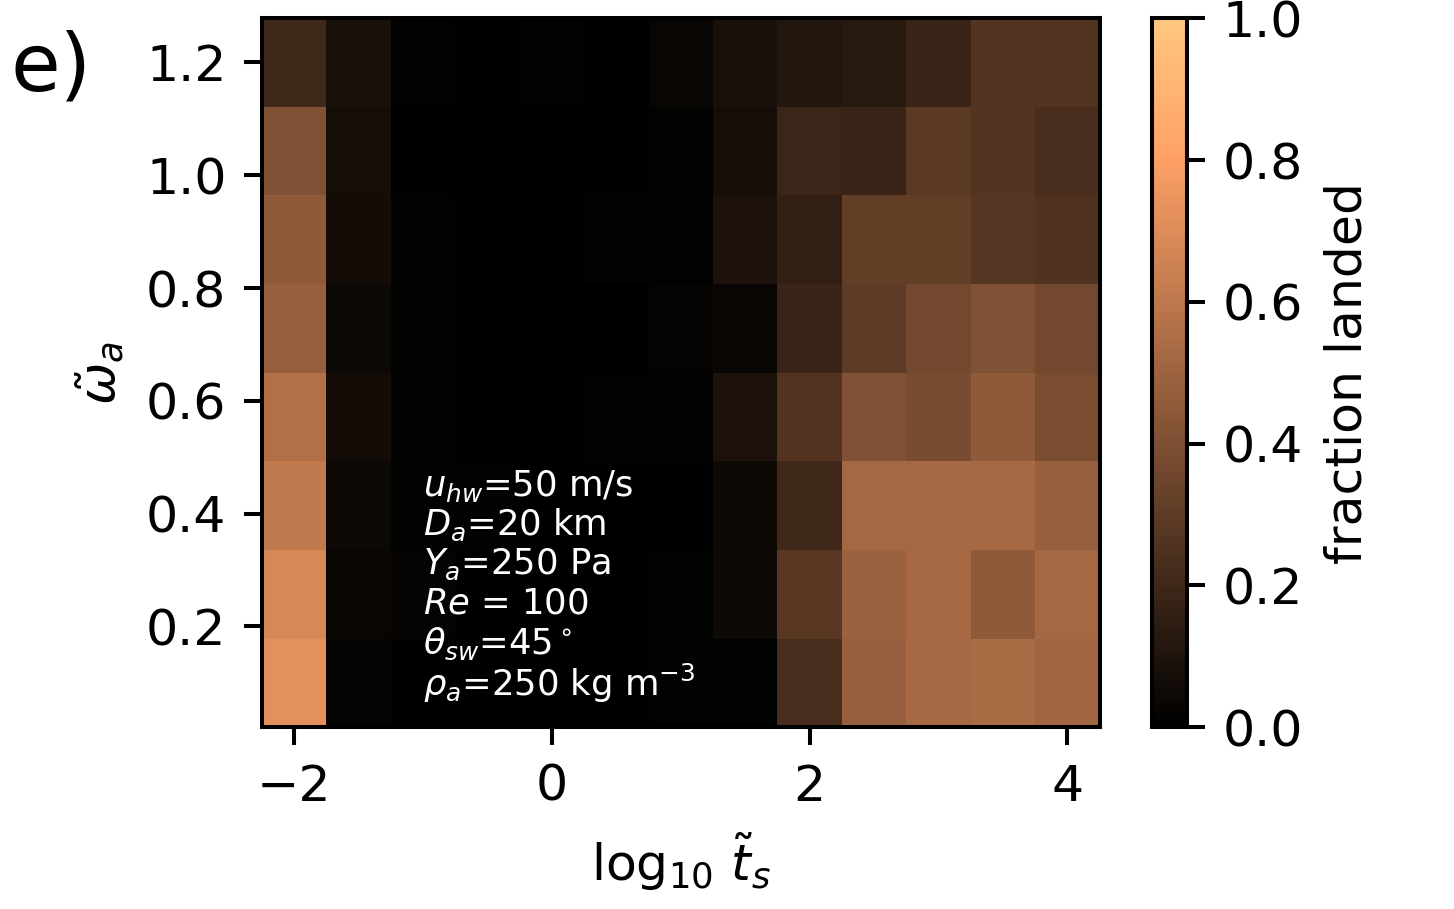

In [107]:
fig,ax = plt.subplots(1,1,figsize=(4,2.5),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.18,right=0.90,top=0.98,bottom=0.2)

im=ax.pcolormesh(lt_d, om_2D,1-nesc_2D_d,shading='auto',cmap='copper',vmin=0,vmax=1)
plt.colorbar(im,label='fraction landed')
ax.set_xlabel(r'log$_{10}$ $\tilde t_s$')
ax.set_ylabel(r'$\tilde \omega_a$')

xll = -1
dz = 0.07
z0 = 0.1
lcolor='white'
ax.text(xll,z0,r'$\rho_a$=250 kg m$^{-3}$',va='center',ha='left',fontsize=7,color=lcolor)
ax.text(xll,z0+dz, r'$\theta_{sw}$=45$^\circ$',va='center',ha='left',fontsize=7,color=lcolor)
ax.text(xll,z0+dz*2, r'$Re$ = 100',va='center',ha='left',fontsize=7,color=lcolor)
ax.text(xll,z0+dz*3, r'$Y_{a}$=250 Pa',va='center',ha='left',fontsize=7,color=lcolor)
ax.text(xll,z0+dz*4, r'$D_a$=20 km',va='center',ha='left',fontsize=7,color=lcolor)
ax.text(xll,z0+dz*5, r'$u_{hw}$=50 m/s',va='center',ha='left',fontsize=7,color=lcolor)

ax.text(-4.2,1.15,'e)',fontsize=16)
plt.savefig('nesc_2D_om.png',dpi=200)

<IPython.core.display.Javascript object>


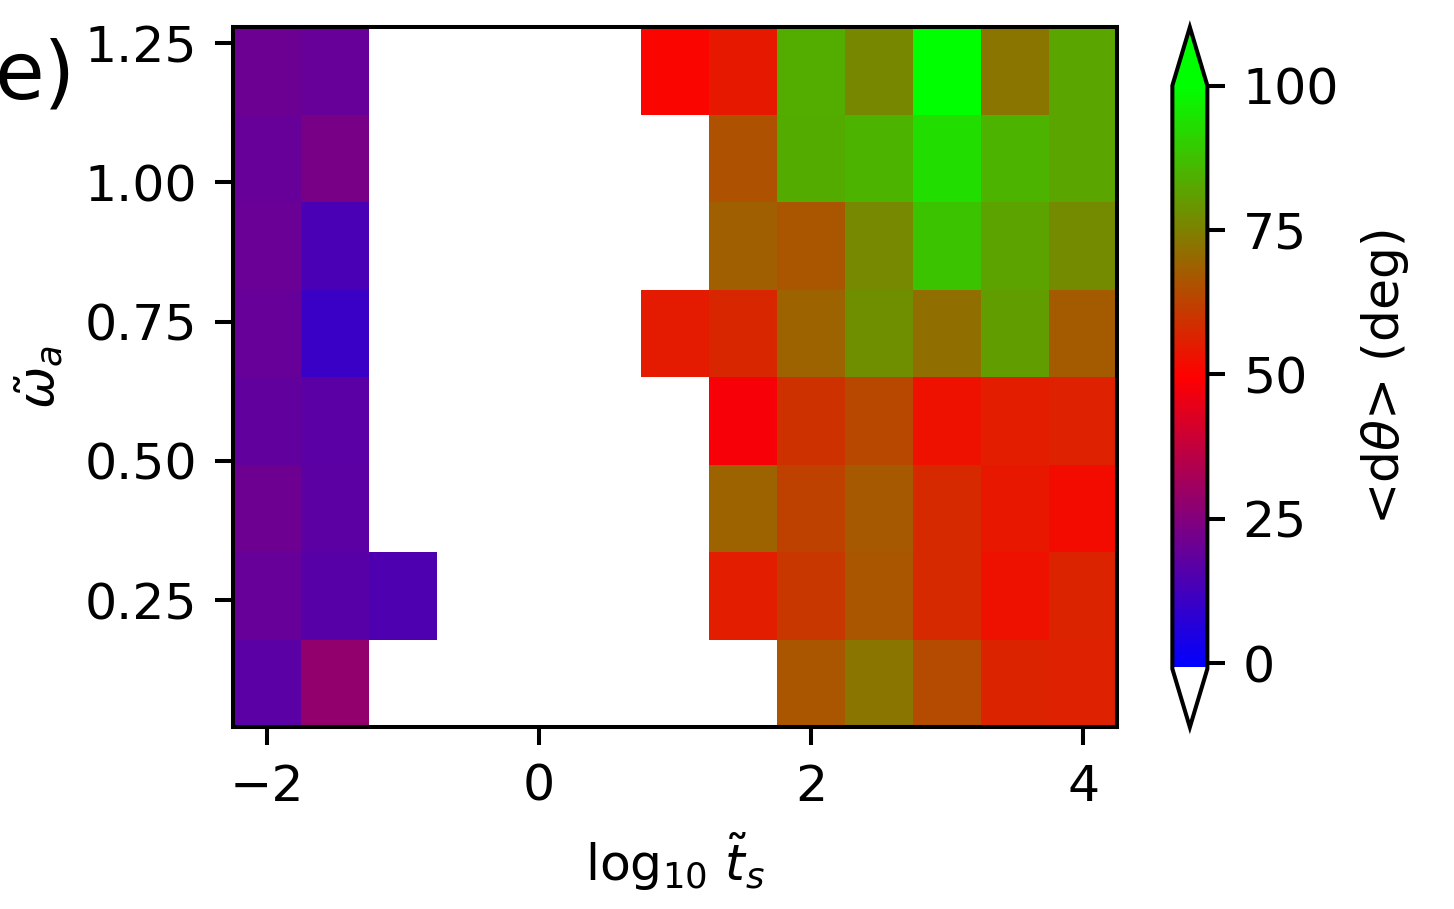

In [119]:
# figure xxx , plot previous <d theta> instead
fig,ax = plt.subplots(1,1,figsize=(4,2.5),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.16,right=0.92,top=0.97,bottom=0.2)

im=ax.pcolormesh(lt_d, om_2D,mean_dt_d*180/np.pi,shading='auto',cmap=newcmp,vmin=-1,vmax=100) # ,vmin=0,vmax=1)
plt.colorbar(im,label=r'<d$\theta$> (deg)',extend='both',extendfrac=0.1)
ax.set_xlabel(r'log$_{10}$ $\tilde t_s$')
ax.set_ylabel(r'$\tilde \omega_a$')

ax.text(-4.0,1.15,'e)',fontsize=16)
plt.savefig('dtheta_2D_om.png',dpi=200)

In [109]:
# parm sweep ts and theta_s spin angle
ts_arr = np.logspace(-2,4.0,13)  # stopping times (dimensionless)
theta_arr = np.linspace(0.0,np.pi,9)  #in radians
print(theta_arr,ts_arr)

Re = 100  # Reynold number of whole body
#theta_s_deg = 45.  # in degrees 
tilde_Omega_a = 0.5

dt = 0.005  # timestep
nc = 100   # number of particles integrated 
rho_a = 250. #mks
u_hw = 50.0 # m/s  # setting by hand 
Y_a = 250.0

ts_2D,theta_2D = np.meshgrid(ts_arr,theta_arr)  # X,Y
lt_f = np.log10(ts_2D)
nesc_2D_f = theta_2D*0.0
mean_dt_f = theta_2D*0.0
D_a_km = 20.0
tilde_uhw,vmax,vmax_vmin_ratio,v_a = get_parms(D_a_km,rho_a,Y_a,u_hw)  # 

for j in range(len(ts_arr)):
    print(j)
    for i in range(len(theta_arr)):
        theta_s = theta_2D[i,j]
        tilde_Omega_a_vec = np.array([np.sin(theta_s), 0.0, np.cos(theta_s)]) *tilde_Omega_a
        tilde_ts = ts_2D[i,j]
        print('ts,thetas',tilde_ts,theta_s)
        dtheta_arr, nesc,theta_init_arr,theta_final_arr = \
            stats2(nc,tilde_Omega_a_vec,vmax,vmax_vmin_ratio,tilde_ts,tilde_uhw,Re,dt)
        nesc_2D_f[i,j] = nesc/nc
        kk = (dtheta_arr >= 0)  # is Boolean
        nk = len(dtheta_arr[kk])
        if (nk>1):
            mean_dt_f[i,j] = np.mean(dtheta_arr[kk])
        else:
            mean_dt_f[i,j] = -100  # false value here
        

[0.         0.39269908 0.78539816 1.17809725 1.57079633 1.96349541
 2.35619449 2.74889357 3.14159265] [1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00 3.16227766e+00 1.00000000e+01 3.16227766e+01
 1.00000000e+02 3.16227766e+02 1.00000000e+03 3.16227766e+03
 1.00000000e+04]
D_a_km=20.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=4.0e-04
tilde_uhw=18.9, tilde_vmax=6.6, tilde_vmin=0.623, vmax_vmin_ratio=10.6
0
ts,thetas 0.01 0.0
ts,thetas 0.01 0.39269908169872414
ts,thetas 0.01 0.7853981633974483
ts,thetas 0.01 1.1780972450961724
ts,thetas 0.01 1.5707963267948966
ts,thetas 0.01 1.9634954084936207
ts,thetas 0.01 2.356194490192345
ts,thetas 0.01 2.748893571891069
ts,thetas 0.01 3.141592653589793
1
ts,thetas 0.03162277660168379 0.0
ts,thetas 0.03162277660168379 0.39269908169872414
ts,thetas 0.03162277660168379 0.7853981633974483
ts,thetas 0.03162277660168379 1.1780972450961724
ts,thetas 0.03162277660168379 1.5707963267948966
ts,thetas 0.03162277660168379 1.963495408493620

<IPython.core.display.Javascript object>


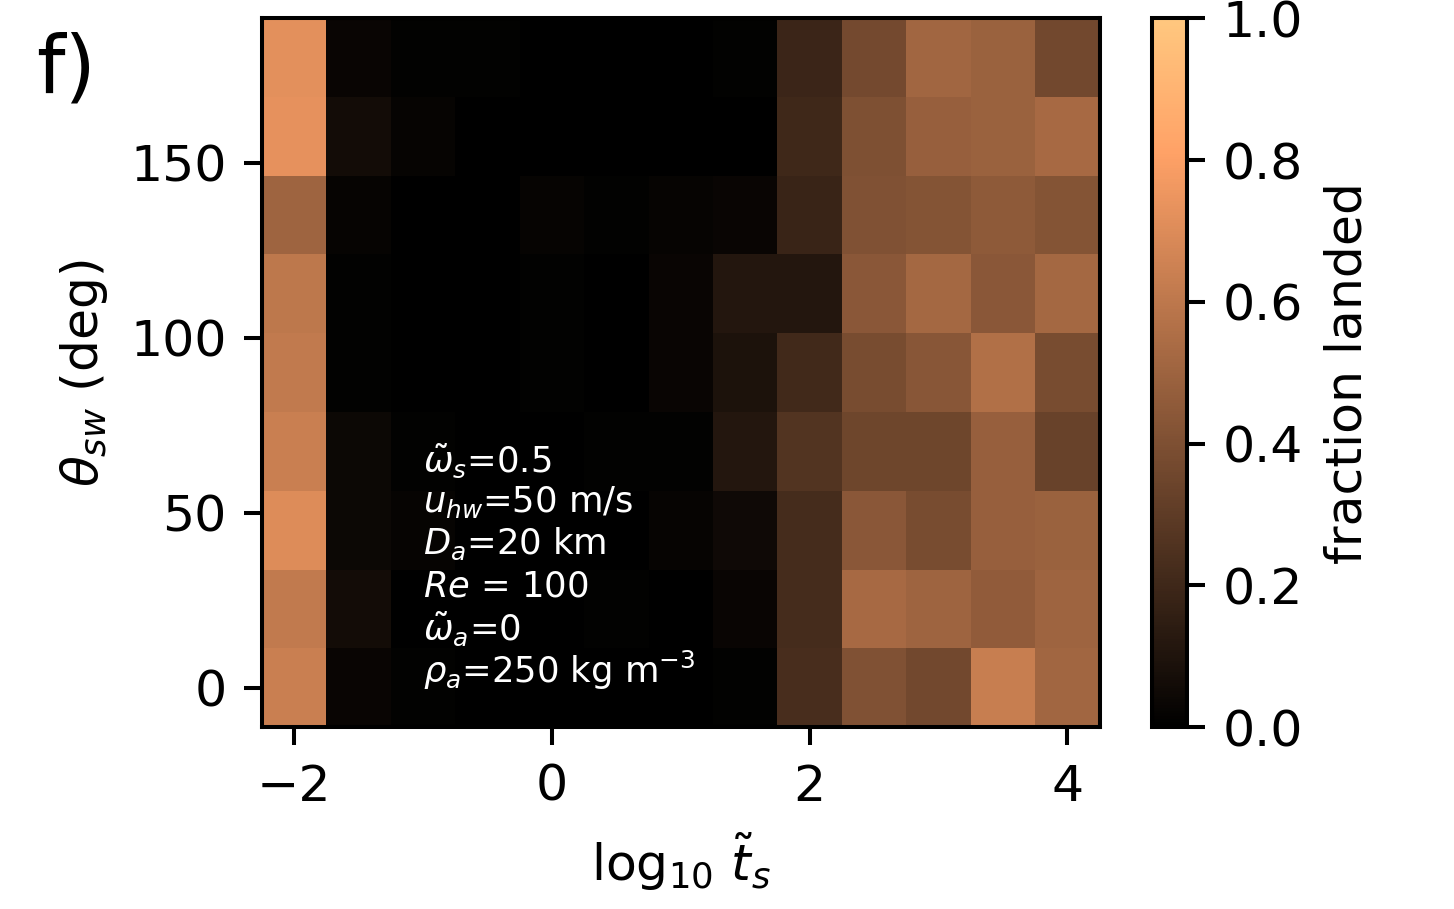

In [110]:
fig,ax = plt.subplots(1,1,figsize=(4,2.5),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.18,right=0.90,top=0.98,bottom=0.2)

im=ax.pcolormesh(lt_f, theta_2D*180/np.pi,1-nesc_2D_f,shading='auto',cmap='copper',vmin=0,vmax=1)
plt.colorbar(im,label='fraction landed')
ax.set_xlabel(r'log$_{10}$ $\tilde t_s$')
ax.set_ylabel(r'$\theta_{sw}$ (deg)')

xll = -1
z0 = 5; dz = 12
lcolor='white'
ax.text(xll,z0,r'$\rho_a$=250 kg m$^{-3}$',va='center',ha='left',fontsize=7,color=lcolor)
ax.text(xll,z0+dz, r'$\tilde \omega_a$=0',va='center',ha='left',fontsize=7,color=lcolor)
ax.text(xll,z0+dz*2, r'$Re$ = 100',va='center',ha='left',fontsize=7,color=lcolor)
#ax.text(xll,z0+dz*3, r'$Y_{a}$=250 Pa',va='center',ha='left',fontsize=7,color=lcolor)
ax.text(xll,z0+dz*3, r'$D_a$=20 km',va='center',ha='left',fontsize=7,color=lcolor)
ax.text(xll,z0+dz*4, r'$u_{hw}$=50 m/s',va='center',ha='left',fontsize=7,color=lcolor)
ax.text(xll,z0+dz*5, r'$\tilde \omega_s$=0.5',va='center',ha='left',fontsize=7,color=lcolor)

ax.text(-4.0,170,'f)',fontsize=16)
plt.savefig('nesc_2D_ths.png',dpi=200)

<IPython.core.display.Javascript object>


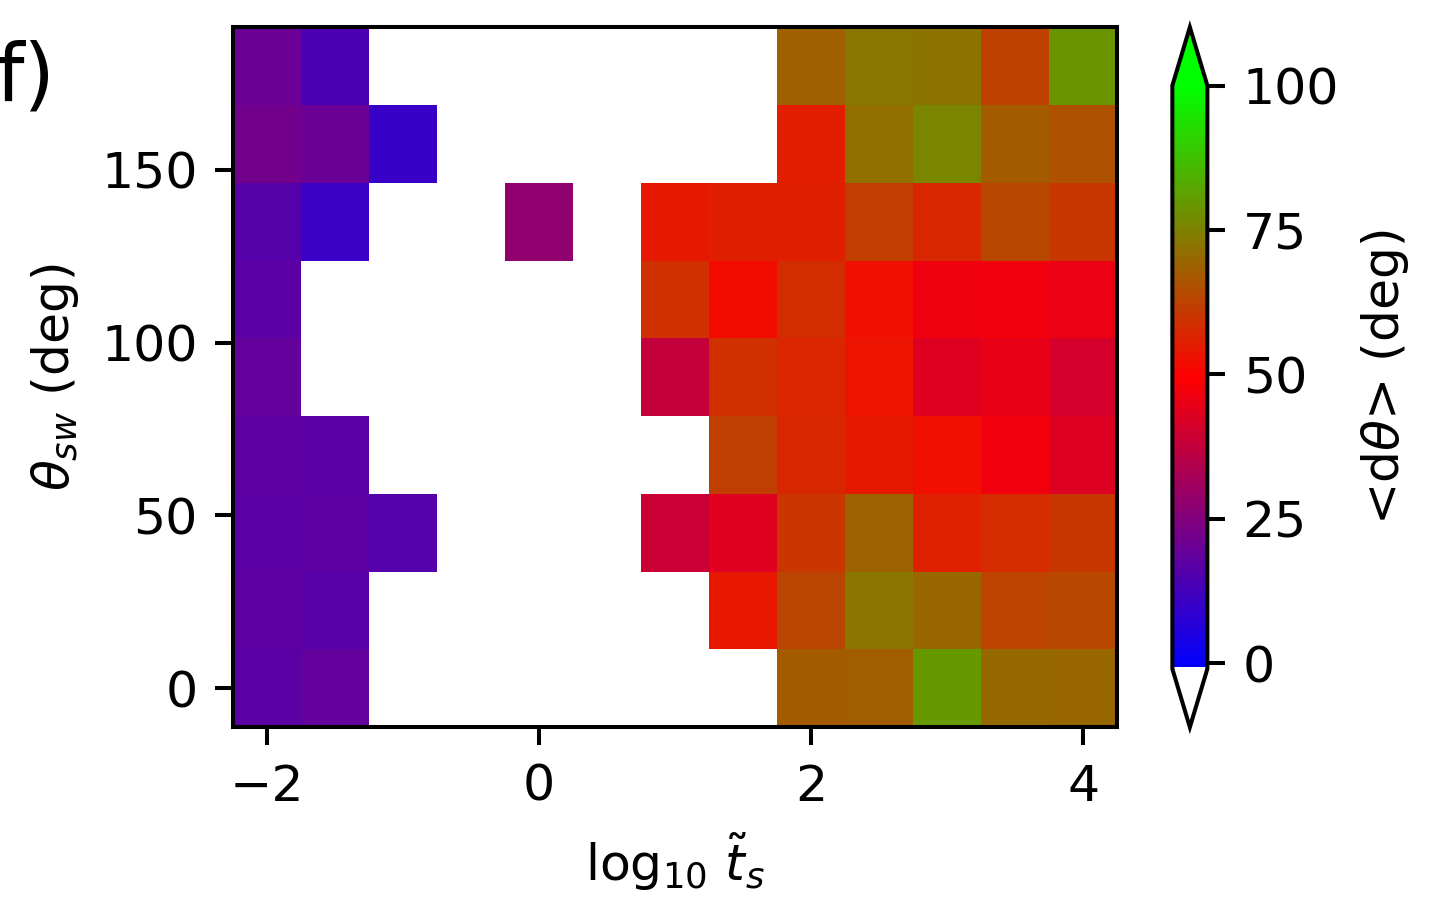

In [120]:
# figure xxx , plot previous <d theta> instead
fig,ax = plt.subplots(1,1,figsize=(4,2.5),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.16,right=0.92,top=0.97,bottom=0.2)

im=ax.pcolormesh(lt_f, theta_2D*180/np.pi,mean_dt_f*180/np.pi,shading='auto',cmap=newcmp,vmin=-1,vmax=100) # ,vmin=0,vmax=1)
plt.colorbar(im,label=r'<d$\theta$> (deg)',extend='both',extendfrac=0.1)
ax.set_xlabel(r'log$_{10}$ $\tilde t_s$')
ax.set_ylabel(r'$\theta_{sw}$ (deg)')

ax.text(-4.0,170,'f)',fontsize=16)
plt.savefig('dtheta_2D_ths.png',dpi=200)

In [ ]:
# below not used

In [275]:
ts_arr = np.logspace(-2,4.0,13)  # stopping times (dimensionless)
rho_arr = np.logspace(1.3,3.3,7)  #in 
print(theta_arr,ts_arr)

Re = 100  # Reynold number of whole body

theta_s_deg = 45.  # in degrees 
theta_s = theta_s_deg*np.pi/180.0   # in radians 
tilde_Omega_a = 0.01
tilde_Omega_a_vec = np.array([np.sin(theta_s), 0.0, np.cos(theta_s)]) *tilde_Omega_a

dt = 0.005  # timestep
nc = 100   # number of particles integrated 
#rho_a = 250. #mks
u_hw = 50.0 # m/s  # setting by hand 
Y_a = 250.0

ts_2D,rho_2D = np.meshgrid(ts_arr,rho_arr)  # X,Y
lt_g = np.log10(ts_2D)
lr_g = np.log10(rho_2D)
nesc_2D_g = rho_2D*0.0
M_a = 7.5e14 # kg  for Arrokoth


for j in range(len(ts_arr)):
    print(j)
    for i in range(len(rho_arr)):
        rho_a = rho_2D[i,j]
        tilde_ts = ts_2D[i,j]
        print('ts,thetas',tilde_ts,rho_a)
        tilde_uhw,vmax,vmax_vmin_ratio,v_a = get_parms_M(M_a,rho_a,Y_a,u_hw) 
        dtheta_arr, nesc,theta_init_arr,theta_final_arr = \
            stats2(nc,tilde_Omega_a_vec,vmax,vmax_vmin_ratio,tilde_ts,tilde_uhw,Re,dt)

        nesc_2D_g[i,j] = nesc/nc

[0.         0.39269908 0.78539816 1.17809725 1.57079633 1.96349541
 2.35619449 2.74889357 3.14159265] [1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00 3.16227766e+00 1.00000000e+01 3.16227766e+01
 1.00000000e+02 3.16227766e+02 1.00000000e+03 3.16227766e+03
 1.00000000e+04]
0
ts,thetas 0.01 19.952623149688797
D_a_km=41.6 km, v_a=1.6 m/s, v_esc=2.2m/s, pi_3=5.0e-03
tilde_uhw=32.2, tilde_vmax=11.2, tilde_vmin=3.757, vmax_vmin_ratio=3.0
ts,thetas 0.01 42.986623470822764
D_a_km=32.2 km, v_a=1.8 m/s, v_esc=2.5m/s, pi_3=2.3e-03
tilde_uhw=28.3, tilde_vmax=9.9, tilde_vmin=2.252, vmax_vmin_ratio=4.4
ts,thetas 0.01 92.61187281287937
D_a_km=24.9 km, v_a=2.0 m/s, v_esc=2.8m/s, pi_3=1.1e-03
tilde_uhw=24.9, tilde_vmax=8.7, tilde_vmin=1.350, vmax_vmin_ratio=6.4
ts,thetas 0.01 199.52623149688787
D_a_km=19.3 km, v_a=2.3 m/s, v_esc=3.2m/s, pi_3=5.0e-04
tilde_uhw=21.9, tilde_vmax=7.7, tilde_vmin=0.809, vmax_vmin_ratio=9.5
ts,thetas 0.01 429.86623470822764
D_a_km=14.9 km, v_a=2.

ts,thetas 10.0 1995.2623149688789
D_a_km=9.0 km, v_a=3.3 m/s, v_esc=4.7m/s, pi_3=5.0e-05
tilde_uhw=15.0, tilde_vmax=5.2, tilde_vmin=0.174, vmax_vmin_ratio=29.9
7
ts,thetas 31.622776601683793 19.952623149688797
D_a_km=41.6 km, v_a=1.6 m/s, v_esc=2.2m/s, pi_3=5.0e-03
tilde_uhw=32.2, tilde_vmax=11.2, tilde_vmin=3.757, vmax_vmin_ratio=3.0
ts,thetas 31.622776601683793 42.986623470822764
D_a_km=32.2 km, v_a=1.8 m/s, v_esc=2.5m/s, pi_3=2.3e-03
tilde_uhw=28.3, tilde_vmax=9.9, tilde_vmin=2.252, vmax_vmin_ratio=4.4
ts,thetas 31.622776601683793 92.61187281287937
D_a_km=24.9 km, v_a=2.0 m/s, v_esc=2.8m/s, pi_3=1.1e-03
tilde_uhw=24.9, tilde_vmax=8.7, tilde_vmin=1.350, vmax_vmin_ratio=6.4
ts,thetas 31.622776601683793 199.52623149688787
D_a_km=19.3 km, v_a=2.3 m/s, v_esc=3.2m/s, pi_3=5.0e-04
tilde_uhw=21.9, tilde_vmax=7.7, tilde_vmin=0.809, vmax_vmin_ratio=9.5
ts,thetas 31.622776601683793 429.86623470822764
D_a_km=14.9 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=2.3e-04
tilde_uhw=19.3, tilde_vmax=6.7, tilde_

<IPython.core.display.Javascript object>


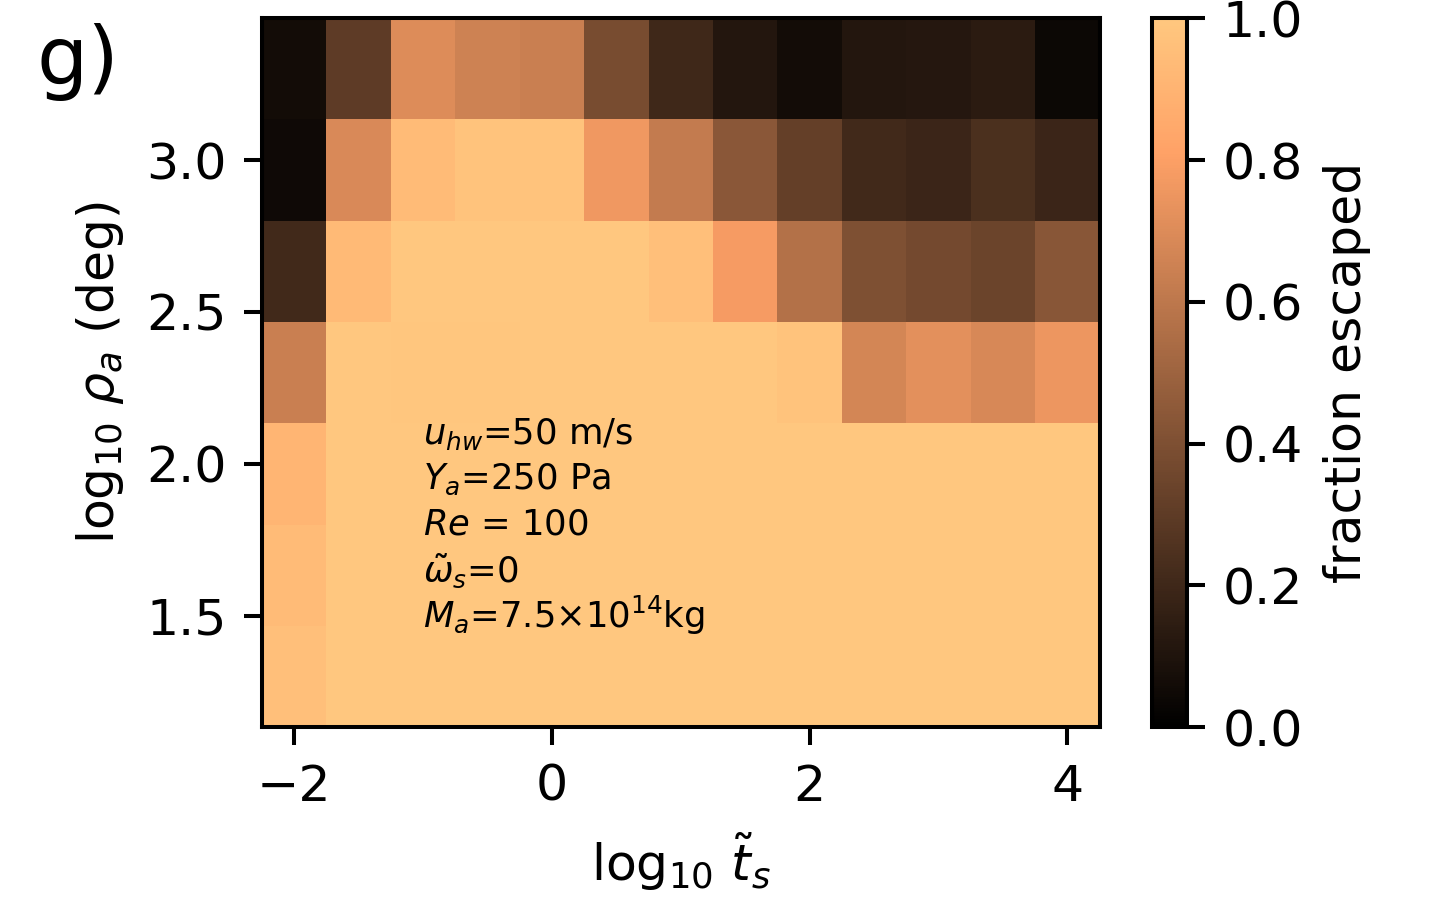

In [353]:
# not used!
fig,ax = plt.subplots(1,1,figsize=(4,2.5),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.18,right=0.90,top=0.98,bottom=0.2)

im=ax.pcolormesh(lt_g, lr_g,nesc_2D_g,shading='auto',cmap='copper',vmin=0,vmax=1)
plt.colorbar(im,label='fraction escaped')
ax.set_xlabel(r'log$_{10}$ $\tilde t_s$')
ax.set_ylabel(r'log$_{10}$ $\rho_a$ (deg)')

xll = -1
z0 = 1.5; dz = 0.15
ax.text(xll,z0,r'$M_a$=7.5$\times 10^{14}$kg',va='center',ha='left',fontsize=7)
ax.text(xll,z0+dz, r'$\tilde \omega_s$=0',va='center',ha='left',fontsize=7)
ax.text(xll,z0+dz*2, r'$Re$ = 100',va='center',ha='left',fontsize=7)
ax.text(xll,z0+dz*3, r'$Y_{a}$=250 Pa',va='center',ha='left',fontsize=7)
#ax.text(xll,z0+dz*3, r'$D_a$=20 km',va='center',ha='left',fontsize=7)
ax.text(xll,z0+dz*4, r'$u_{hw}$=50 m/s',va='center',ha='left',fontsize=7)
#ax.text(xll,z0+dz*5, r'$\tilde \omega_s$=0.5',va='center',ha='left',fontsize=7)

ax.text(-4.0,3.25,'g)',fontsize=16)
plt.savefig('nesc_2D_g.png',dpi=200)

In [122]:
# not used
ts_arr = np.logspace(-2,4.0,13)  # stopping times (dimensionless)
D_a_km_arr = np.logspace(1,2,8)
print(D_a_km_arr,ts_arr)

Re = 1e6  # Reynold number of whole body
theta_s_deg = 45.  # in degrees 
theta_s = theta_s_deg*np.pi/180.0   # in radians 
tilde_Omega_a = 0.001
tilde_Omega_a_vec = np.array([np.sin(theta_s), 0.0, np.cos(theta_s)]) *tilde_Omega_a
dt = 0.005  # timestep
nc = 100   # number of particles integrated 
rho_a = 1000. #mks
u_hw = 50.0 # m/s  # setting by hand 
Y_a = 500.0

ts_2D,D_a_2D = np.meshgrid(ts_arr,D_a_km_arr)  # X,Y
lt_a = np.log10(ts_2D)
lD_a = np.log10(D_a_2D)
nesc_2D_a = D_a_2D*0.0
for j in range(len(ts_arr)):
    print(j)
    for i in range(len(D_a_km_arr)):
        D_a_km = D_a_2D[i,j]
        tilde_ts = ts_2D[i,j]
        print('ts,Da',tilde_ts,D_a_km)
        tilde_uhw,vmax,vmax_vmin_ratio,v_a = get_parms(D_a_km,rho_a,Y_a,u_hw)
        dtheta_arr, nesc,theta_init_arr,theta_final_arr = \
            stats2(nc,tilde_Omega_a_vec,vmax,vmax_vmin_ratio,tilde_ts,tilde_uhw,Re,dt)
        nesc_2D_a[i,j] = nesc/nc

[ 10.          13.89495494  19.30697729  26.82695795  37.2759372
  51.79474679  71.9685673  100.        ] [1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00 3.16227766e+00 1.00000000e+01 3.16227766e+01
 1.00000000e+02 3.16227766e+02 1.00000000e+03 3.16227766e+03
 1.00000000e+04]
0
ts,Da 10000.0 10.0
D_a_km=10.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=2.0e-04
tilde_uhw=18.9, tilde_vmax=6.6, tilde_vmin=0.441, vmax_vmin_ratio=15.0
ts,Da 10000.0 13.894954943731374
D_a_km=13.9 km, v_a=3.7 m/s, v_esc=5.2m/s, pi_3=2.0e-04
tilde_uhw=13.6, tilde_vmax=4.7, tilde_vmin=0.317, vmax_vmin_ratio=15.0
ts,Da 10000.0 19.306977288832496
D_a_km=19.3 km, v_a=5.1 m/s, v_esc=7.2m/s, pi_3=2.0e-04
tilde_uhw=9.8, tilde_vmax=3.4, tilde_vmin=0.228, vmax_vmin_ratio=15.0
ts,Da 10000.0 26.826957952797258
D_a_km=26.8 km, v_a=7.1 m/s, v_esc=10.0m/s, pi_3=2.0e-04
tilde_uhw=7.0, tilde_vmax=2.5, tilde_vmin=0.164, vmax_vmin_ratio=15.0
ts,Da 10000.0 37.2759372031494
D_a_km=37.3 km, v_a=9.9 m/s, v_esc=1

ts,Da 10000.0 26.826957952797258
D_a_km=26.8 km, v_a=7.1 m/s, v_esc=10.0m/s, pi_3=2.0e-04
tilde_uhw=7.0, tilde_vmax=2.5, tilde_vmin=0.164, vmax_vmin_ratio=15.0
ts,Da 10000.0 37.2759372031494
D_a_km=37.3 km, v_a=9.9 m/s, v_esc=13.9m/s, pi_3=2.0e-04
tilde_uhw=5.1, tilde_vmax=1.8, tilde_vmin=0.118, vmax_vmin_ratio=15.0
ts,Da 10000.0 51.7947467923121
D_a_km=51.8 km, v_a=13.7 m/s, v_esc=19.4m/s, pi_3=2.0e-04
tilde_uhw=3.7, tilde_vmax=1.3, tilde_vmin=0.085, vmax_vmin_ratio=15.0
ts,Da 10000.0 71.96856730011521
D_a_km=72.0 km, v_a=19.0 m/s, v_esc=26.9m/s, pi_3=2.0e-04
tilde_uhw=2.6, tilde_vmax=0.9, tilde_vmin=0.061, vmax_vmin_ratio=15.0
ts,Da 10000.0 100.0
D_a_km=100.0 km, v_a=26.4 m/s, v_esc=37.4m/s, pi_3=2.0e-04
tilde_uhw=1.9, tilde_vmax=0.7, tilde_vmin=0.044, vmax_vmin_ratio=15.0
7
ts,Da 10000.0 10.0
D_a_km=10.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=2.0e-04
tilde_uhw=18.9, tilde_vmax=6.6, tilde_vmin=0.441, vmax_vmin_ratio=15.0
ts,Da 10000.0 13.894954943731374
D_a_km=13.9 km, v_a=3.7 m/s, v_es

<IPython.core.display.Javascript object>


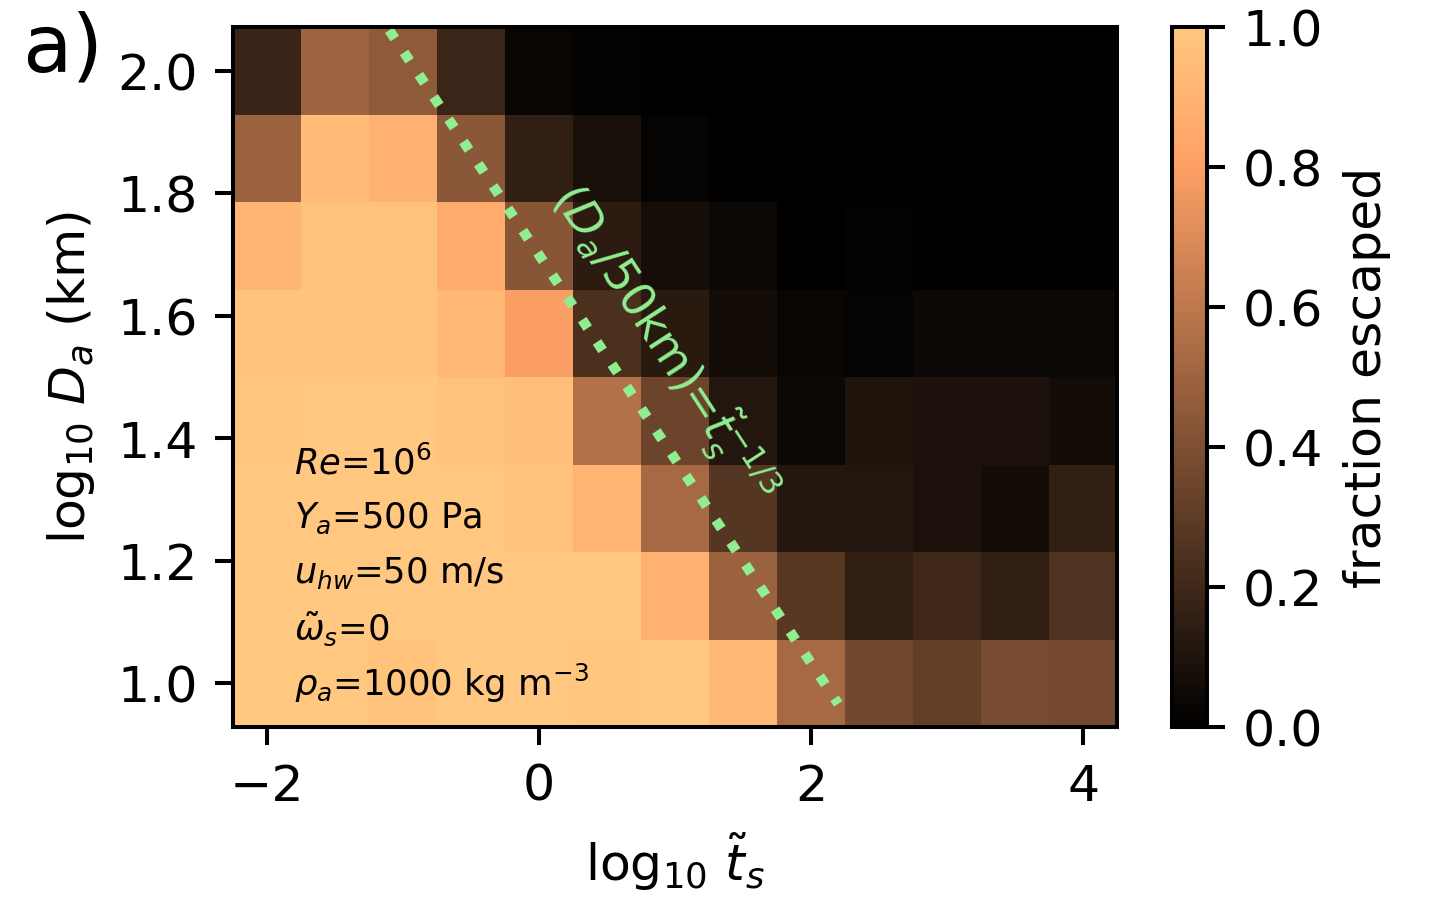

In [239]:
#not used!
fig,ax = plt.subplots(1,1,figsize=(4,2.5),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.16,right=0.92,top=0.97,bottom=0.2)

im=ax.pcolormesh(lt_a, lD_a,nesc_2D_a,shading='auto',cmap='copper',vmin=0,vmax=1)
plt.colorbar(im,label='fraction escaped')
ax.set_xlabel(r'log$_{10}$ $\tilde t_s$')
ax.set_ylabel(r'log$_{10}$ $D_a$ (km)')
xll = -1.8
dz = 0.09; y0=1
ax.text(xll,y0,r'$\rho_a$=1000 kg m$^{-3}$',va='center',ha='left',fontsize=7)
ax.text(xll,y0+dz, r'$\tilde \omega_a$=0',va='center',ha='left',fontsize=7)
ax.text(xll,y0+dz*2, r'$u_{hw}$=50 m/s',va='center',ha='left',fontsize=7)
ax.text(xll,y0+dz*3, r'$Y_{a}$=500 Pa',va='center',ha='left',fontsize=7)
ax.text(xll,y0+dz*4, r'$Re$=$10^6$',va='center',ha='left',fontsize=7)

tlin = np.linspace(-1.1,2.2,10)
Dlin = (tlin-2)*-0.3333  + 1
Dlin = tlin*-0.3333  + 1.7
ax.plot(tlin,Dlin,':',lw=2,color='lightgreen')
# this curve is (D/10) = (tilde t/100)^1/3
# equivalently tilde t/100 = (D/10)^3
ax.text(0.0,1.3,r'$(D_a/50$km)=$\tilde t_s^{-1/3}$',rotation=-57,color='lightgreen',fontsize=9)

ax.text(-3.8,2,'a)',fontsize=16)
plt.savefig('nesc_2D_a.png',dpi=200)